In [1]:
pip install strawberryfields --upgrade

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.4 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.2-py3-none-any.whl size=144544 sha256=5a0930dbea68ad9ce944ac959922302563faeb4b2db0f2ca9479f0524dc59db8
  Stored in directory: /Users/shreyupadhyay/Library/Caches/pip/wheels/83/c0/ea/4bbf0c91792ecbd6385b21b8144b0fe45f41b914c7e6a130a2
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=a1cd5ba645ac113d282c98e72360cb84c80fe66d90f8375b8601bc8caafc86bf
  Stored in directory: /Users/shreyupadhyay/Library/Caches/pip/wheels/97/4a/3f/f6f222440f03d888f026ac848b6b4ea57183ebfcd8f3cb8904
Successfully built antlr4-python3-runtime fire
Note: you may need to restart the kernel to us

In [12]:
pip install xanadu-cloud-client

Note: you may need to restart the kernel to use updated packages.


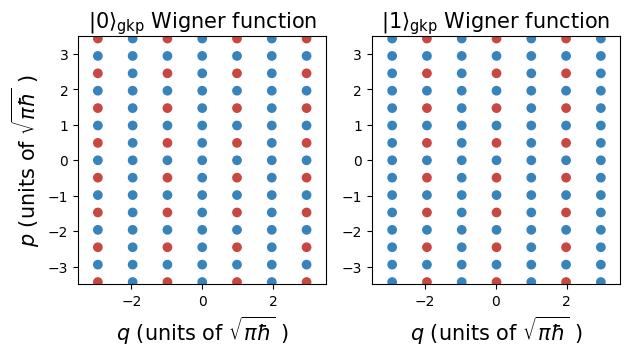

In [16]:
# Import relevant libraries
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar


sf.hbar = 1
scale = np.sqrt(sf.hbar * np.pi)

# Create a GKP |0> state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP() | q

eng = sf.Engine("bosonic")
gkp_0 = eng.run(prog).state

# Create a GKP |1> state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP() | q
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q

eng = sf.Engine("bosonic")
gkp_1 = eng.run(prog).state

# Get the phase space coordinates of the delta functions for the two states
q_coords_0 = gkp_0.means().real[:, 0]
p_coords_0 = gkp_0.means().real[:, 1]
q_coords_1 = gkp_1.means().real[:, 0]
p_coords_1 = gkp_1.means().real[:, 1]

# Determine whether the delta functions are positively or negatively weighted
delta_sign_0 = np.sign(gkp_0.weights().real)
delta_sign_1 = np.sign(gkp_1.weights().real)

# Plot the locations and signs of the deltas
fig,ax = plt.subplots(1, 2)
ax[0].scatter(q_coords_0 / scale,
           p_coords_0 / scale,
           c=delta_sign_0,
           cmap=plt.cm.RdBu, vmin=-1.5, vmax=1.5)
ax[1].scatter(q_coords_1 / scale,
           p_coords_1 / scale,
           c=delta_sign_0,
           cmap=plt.cm.RdBu, vmin=-1.5, vmax=1.5)
for i in range(2):
    ax[i].set_xlim(-3.5, 3.5)
    ax[i].set_ylim(-3.5, 3.5)
    ax[i].set_xlabel(r'$q$ (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
    ax[i].set_aspect("equal")
ax[0].set_title(r'$|0\rangle_{\rm gkp}$ Wigner function', fontsize=15)
ax[1].set_title(r'$|1\rangle_{\rm gkp}$ Wigner function', fontsize=15)
ax[0].set_ylabel(r'$p$ (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
fig.tight_layout()
plt.show()

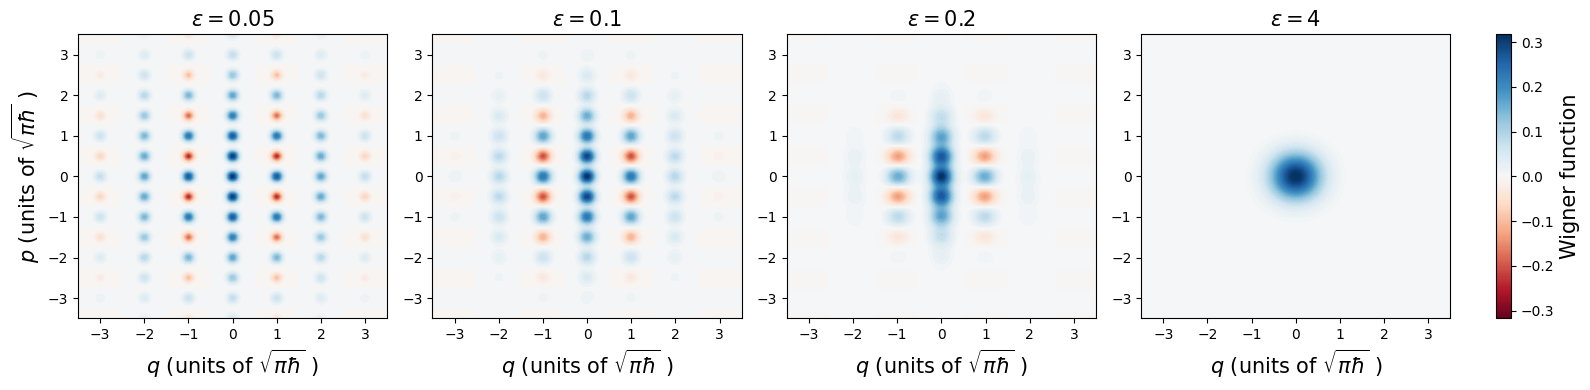

In [17]:
# Choose some values of epsilon
epsilons = [0.05, 0.1, 0.2, 4]

# Pick a region of phase space to plot
quad = np.linspace(-3.5, 3.5, 200) * scale

wigners = []

for epsilon in epsilons:

    # Create a GKP |0> state
    prog = sf.Program(1)

    with prog.context as q:
        sf.ops.GKP(epsilon=epsilon) | q

    eng = sf.Engine("bosonic")
    gkp = eng.run(prog).state

    # Calculate the Wigner function
    wigner = gkp.wigner(mode=0, xvec=quad, pvec=quad)
    wigners.append(wigner)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(16, 4), gridspec_kw={"width_ratios": [1, 1, 1, 1, 0.05]})
cmap = plt.cm.RdBu
cmax = np.real_if_close(np.amax(np.array(wigners)))
norm = colors.Normalize(vmin=-cmax, vmax=cmax)
cb1 = colorbar.ColorbarBase(axs[4], cmap=cmap, norm=norm, orientation="vertical")
for i in range(4):
    axs[i].contourf(
        quad / scale,
        quad / scale,
        wigners[i],
        levels=60,
        cmap=plt.cm.RdBu,
        vmin=-cmax,
        vmax=cmax,
    )
    axs[i].set_title(r'$\epsilon =$'+str(epsilons[i]), fontsize=15)
    axs[i].set_xlabel(r'$q$ (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
axs[0].set_ylabel(r'$p$ (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
cb1.set_label("Wigner function", fontsize=15)
fig.tight_layout()
plt.show()

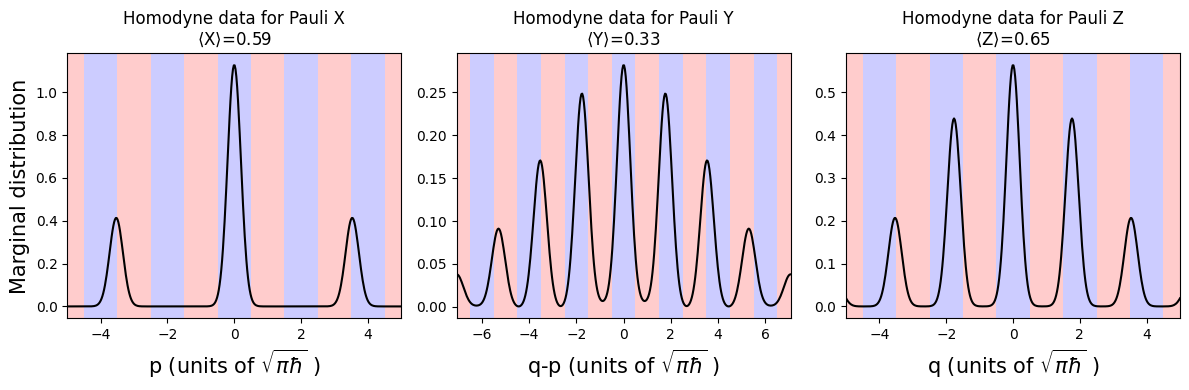

In [25]:
# Create a GKP |+> state
plus = [np.pi / 2, 0]
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=plus, epsilon=0.08) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

def calc_and_plot_marginals(state, mode):
    '''Calculates and plots the p, q-p, and q quadrature marginal
    distributions for a given circuit mode. These can be used to determine
    the Pauli X, Y, and Z outcomes for a GKP qubit.

    Args:
        state (object): a strawberryfields ``BaseBosonicState`` object
        mode (int): index for the circuit mode
    '''
    # Calculate the marginal distributions.
    # The rotation angle in phase space is specified by phi
    marginals = []
    phis = [np.pi / 2, -np.pi / 4, 0]
    quad = np.linspace(-5, 5, 400) * scale
    for phi in phis:
        marginals.append(state.marginal(mode, quad, phi=phi))

    # Plot the results
    paulis = ["X", "Y", "Z"]
    homodynes = ["p", "q-p", "q"]
    expectations = np.zeros(3)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        if i == 1:
            # Rescale the outcomes for Pauli Y
            y_scale = np.sqrt(2 * sf.hbar) / scale
            axs[i].plot(quad * y_scale, marginals[i] / y_scale, 'k-')
            axs[i].set_xlim(quad[0] * y_scale, quad[-1] * y_scale)

            # Calculate Pauli expectation value
            # Blue bins are weighted +1, red bins are weighted -1
            bin_weights = 2 * (((quad * y_scale - 0.5) // 1) % 2) - 1
            integrand = (marginals[i] / y_scale) * bin_weights
            expectations[i] = np.trapz(integrand, quad * y_scale)
        else:
            axs[i].plot(quad / scale, marginals[i] * scale, 'k-')
            axs[i].set_xlim(quad[0] / scale, quad[-1] / scale)

            # Calculate Pauli expectation value
            # Blue bins are weighted +1, red bins are weighted -1
            bin_weights = 2 * (((quad / scale - 0.5) // 1) % 2) - 1
            integrand = (marginals[i] * scale) * bin_weights
            expectations[i] = np.trapz(integrand, quad / scale)

        # Color the qubit bins blue and red
        for j in range(-10, 10):
            axs[i].axvspan((2 * j - 0.5), (2 * j + 0.5), alpha=0.2, facecolor='b')
            axs[i].axvspan((2 * j + 0.5), (2 * j + 1.5), alpha=0.2, facecolor='r')

        axs[i].set_title("Homodyne data for Pauli " + paulis[i] +
                         "\n" + r'$\langle$'+paulis[i]+r'$\rangle$='+
                         str(np.around(expectations[i],2)))
        axs[i].set_xlabel(homodynes[i] + r' (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
    axs[0].set_ylabel("Marginal distribution", fontsize=15)
    fig.tight_layout()
    plt.show()

calc_and_plot_marginals(gkp, 0)

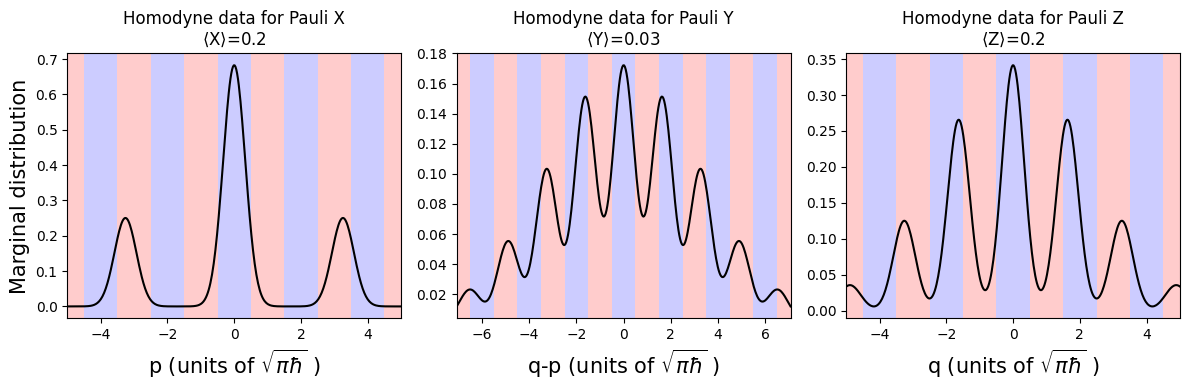

In [26]:
# Create a GKP |+> state and apply loss
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=plus, epsilon=0.08) | q
    sf.ops.LossChannel(0.85) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

#Calculate and plot marginals
calc_and_plot_marginals(gkp, 0)


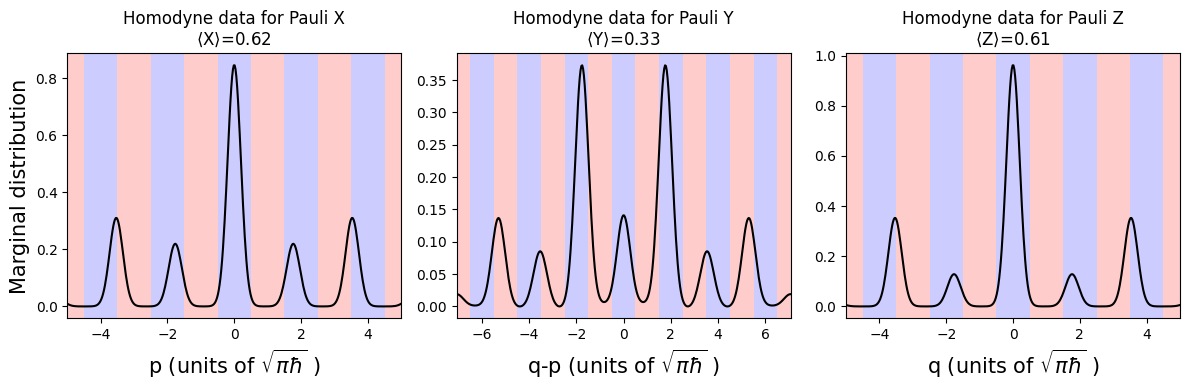

In [27]:
# Create a GKP state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=[np.pi / 4, np.pi / 4], epsilon=0.08) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

#Calculate and plot marginals
calc_and_plot_marginals(gkp, 0)


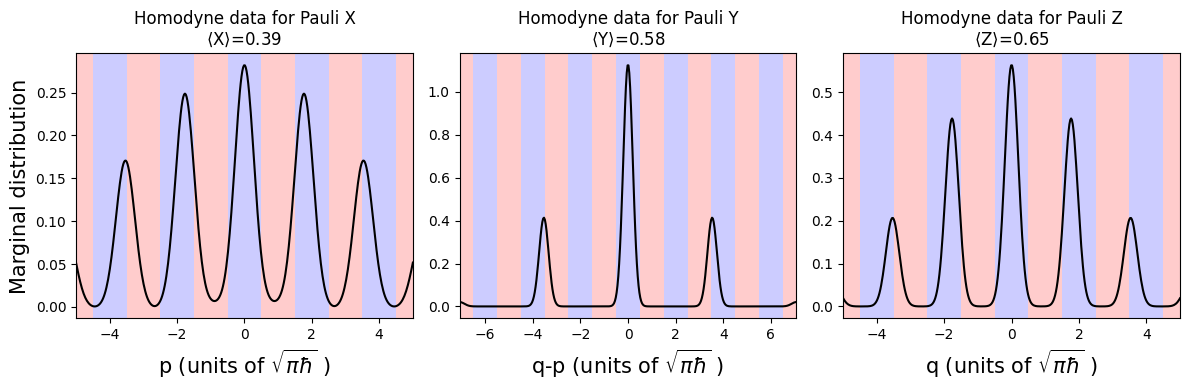

In [28]:
# Create a GKP |+> state and apply a phase gate
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=plus, epsilon=0.08) | q
    sf.ops.Pgate(1) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

calc_and_plot_marginals(gkp, 0)

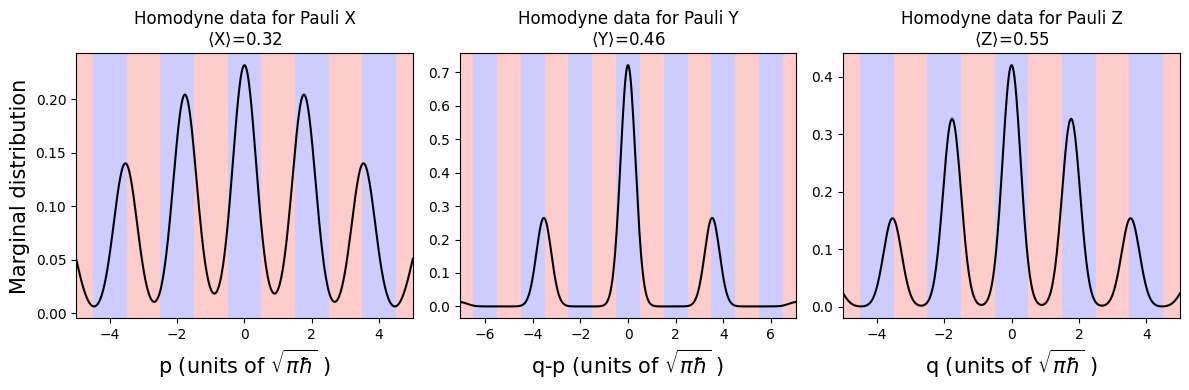

In [30]:
def MPgate(q, s, r_anc, eta_anc, avg):
    '''Applies a CV phase gate to a given mode using measurement-based squeezing.

    Args:
        q (object): label for the mode in the strawberryfields program
        s (float): the ideal phase gate parameter
        r_anc (float): level of squeezing in the ancillary mode
        eta_anc (0 <= float <= 1): detector efficiency for the ancillary mode
        avg (bool): True (False) applies the average (single-shot) mapping
    '''
    r = np.arccosh(np.sqrt(1 + s ** 2 / 4))
    theta = np.arctan(s / 2)
    phi = - np.pi / 2 * np.sign(s) - theta
    sf.ops.MSgate(r, phi, r_anc, eta_anc, avg) | q
    sf.ops.Rgate(theta) | q

prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=plus, epsilon=0.08) | q
    MPgate(q, 1, r_anc=1.2, eta_anc=0.95, avg=True)

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

calc_and_plot_marginals(gkp, 0)


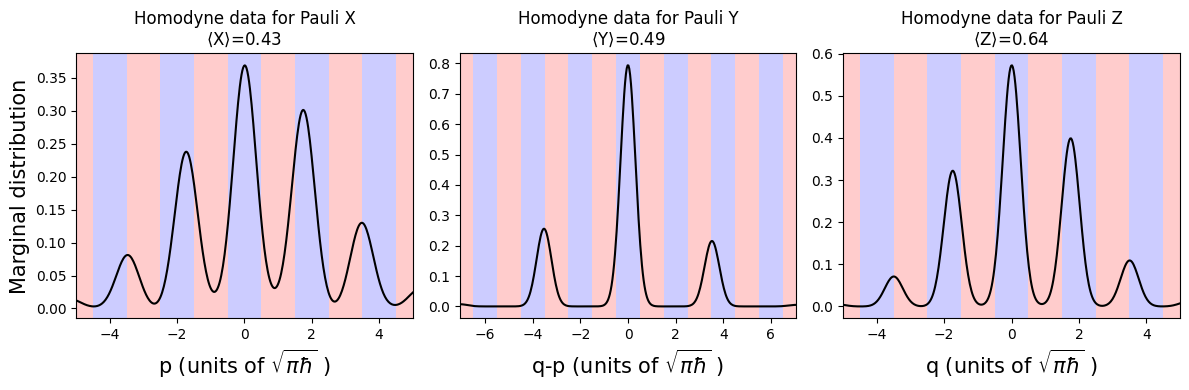

In [31]:
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=plus, epsilon=0.08) | q
    MPgate(q, 1, r_anc=1.2, eta_anc=0.95, avg=False)

eng = sf.Engine("bosonic")
results = eng.run(prog)
gkp = results.state

calc_and_plot_marginals(gkp, 0)

In [32]:
print(results.ancillae_samples)

{0: [-0.5679497823138872]}


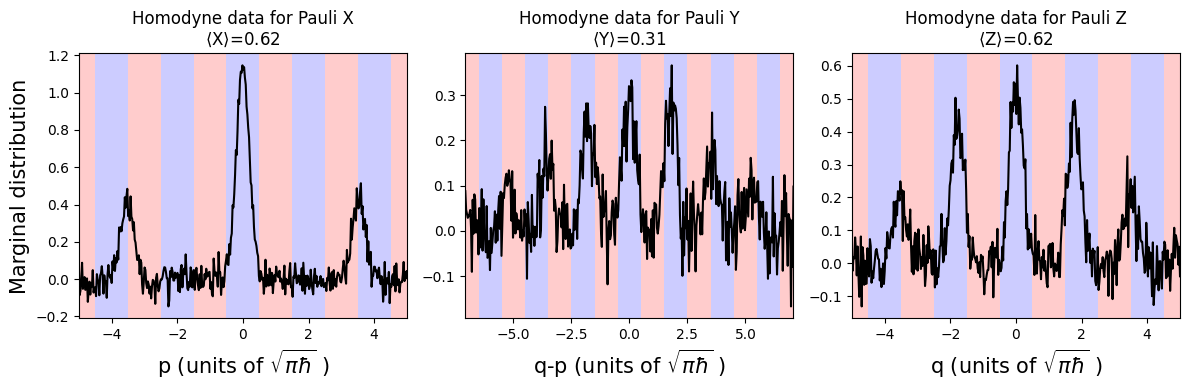

In [86]:
# Import relevant libraries
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Create a GKP |+> state
plus = [np.pi / 2, 0]
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=plus, epsilon=0.08) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

# Set a scale for the quadrature space
scale = 1.0

def calc_and_plot_marginals(state, mode):
    '''Calculates and plots the p, q-p, and q quadrature marginal
    distributions for a given circuit mode. These can be used to determine
    the Pauli X, Y, and Z outcomes for a GKP qubit.

    Args:
        state (object): a strawberryfields ``BaseBosonicState`` object
        mode (int): index for the circuit mode
    '''
    # Calculate the marginal distributions.
    marginals = []
    phis = [np.pi / 2, -np.pi / 4, 0]
    quad = np.linspace(-5, 5, 400) * scale
    for phi in phis:
        marginals.append(state.marginal(mode, quad, phi=phi))

    # Initialize a list to store data
    data = []

    for i in range(3):
        if i == 1:
            y_scale = np.sqrt(2 * sf.hbar) / scale
            marginal = marginals[i] / y_scale
        else:
            marginal = marginals[i] * scale
        
        # Add noise
        noise = np.random.normal(0, 0.05, marginal.shape)
        noisy_marginal = marginal + noise
        
        # Store the noisy data
        data.append(noisy_marginal)
    
    # Convert data to a DataFrame
    df = pd.DataFrame({
        'Homodyme Detector 4': quad,
        'Homodyme Detector 1': data[0],
        'Homodyme Detector 2': data[1],
        'Homodyme Detector 3': data[2]
    })

    # Add a fourth column of random noise
    df['Random_Noise'] = np.random.normal(0, 0.05, df.shape[0])

    # Save to CSV file
    df.to_csv('/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv', index=False)
    
    # Plot the results
    paulis = ["X", "Y", "Z"]
    homodynes = ["p", "q-p", "q"]
    expectations = np.zeros(3)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        if i == 1:
            axs[i].plot(quad * y_scale, data[i], 'k-')
            axs[i].set_xlim(quad[0] * y_scale, quad[-1] * y_scale)

            bin_weights = 2 * (((quad * y_scale - 0.5) // 1) % 2) - 1
            integrand = data[i] * bin_weights
            expectations[i] = np.trapz(integrand, quad * y_scale)
        else:
            axs[i].plot(quad / scale, data[i], 'k-')
            axs[i].set_xlim(quad[0] / scale, quad[-1] / scale)

            bin_weights = 2 * (((quad / scale - 0.5) // 1) % 2) - 1
            integrand = data[i] * bin_weights
            expectations[i] = np.trapz(integrand, quad / scale)

        for j in range(-10, 10):
            axs[i].axvspan((2 * j - 0.5), (2 * j + 0.5), alpha=0.2, facecolor='b')
            axs[i].axvspan((2 * j + 0.5), (2 * j + 1.5), alpha=0.2, facecolor='r')

        axs[i].set_title("Homodyne data for Pauli " + paulis[i] +
                         "\n" + r'$\langle$'+paulis[i]+r'$\rangle$='+
                         str(np.around(expectations[i],2)))
        axs[i].set_xlabel(homodynes[i] + r' (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
    axs[0].set_ylabel("Marginal distribution", fontsize=15)
    fig.tight_layout()
    plt.show()

calc_and_plot_marginals(gkp, 0)


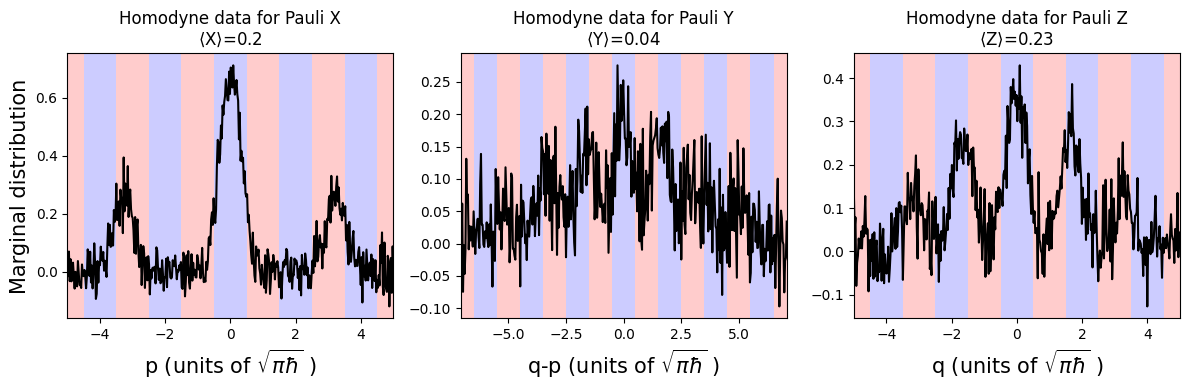

In [87]:
# Create a GKP |+> state and apply loss
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=plus, epsilon=0.08) | q
    sf.ops.LossChannel(0.85) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

#Calculate and plot marginals
calc_and_plot_marginals(gkp, 0)

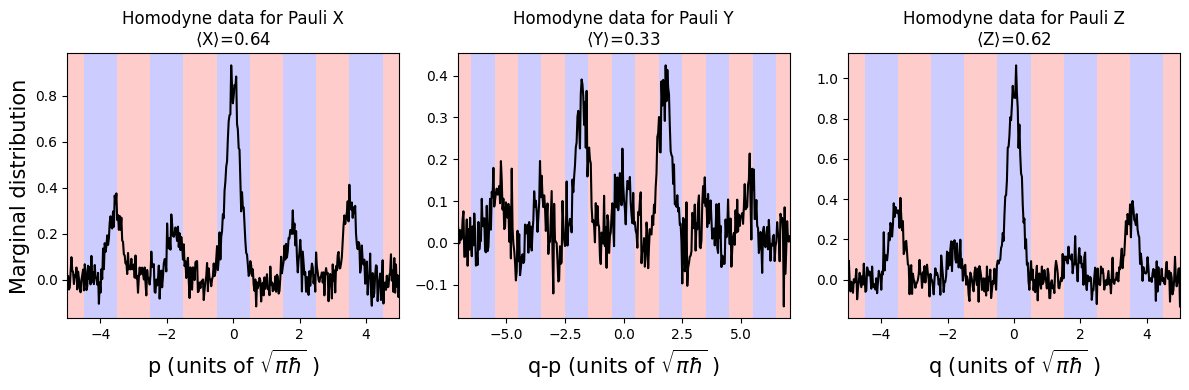

In [88]:
# Create a GKP state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=[np.pi / 4, np.pi / 4], epsilon=0.08) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

#Calculate and plot marginals
calc_and_plot_marginals(gkp, 0)

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the CSV data
df = pd.read_csv('/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv')

# Divide the data into 70:30 ratio
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Prepare the features and target
X_train = train_data[['Homodyme Detector 1', 'Homodyme Detector 2', 'Homodyme Detector 3', 'Homodyme Detector 4']]
y_train = train_data['Random_Noise']
X_test = test_data[['Homodyme Detector 1', 'Homodyme Detector 2', 'Homodyme Detector 3', 'Homodyme Detector 4']]
y_test = test_data['Random_Noise']

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Repeat the training and testing process 4 times
n_repeats = 4
mse_scores = []

for i in range(n_repeats):
    print(f"Iteration {i+1}/{n_repeats}")
    
    # Use 3 times as training data and 1 time as testing data
    # Shuffle and split the data
    X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, y_train, test_size=0.25, random_state=i*10)

    # Train the model
    model.fit(X_train_part, y_train_part)

    # Test the model
    y_pred = model.predict(X_test_part)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test_part, y_pred)
    mse_scores.append(mse)

    print(f"Mean Squared Error for iteration {i+1}: {mse}")

# Final testing on the original test set
final_predictions = model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
print(f"\nFinal Test Mean Squared Error on the original test set: {final_mse}")

# Output the MSE scores
print("\nMSE Scores for each iteration:", mse_scores)


Iteration 1/4
Mean Squared Error for iteration 1: 0.003065306851839105
Iteration 2/4
Mean Squared Error for iteration 2: 0.002981627574147735
Iteration 3/4
Mean Squared Error for iteration 3: 0.0026950416657733852
Iteration 4/4
Mean Squared Error for iteration 4: 0.002712670208680955

Final Test Mean Squared Error on the original test set: 0.003248437301055104

MSE Scores for each iteration: [0.003065306851839105, 0.002981627574147735, 0.0026950416657733852, 0.002712670208680955]


In [94]:


# Assume the following mapping of columns to qubits:
# Qubit 0, 1, 2: 'Quadrature', 'Pauli_X', 'Pauli_Y', 'Pauli_Z' (Noisy qubits for training)
# Qubit 3: A clean qubit (assumed clean qubit data)

# Prepare the features and targets for the noisy qubits
X_train = df[['Homodyme Detector 1', 'Homodyme Detector 2', 'Homodyme Detector 3', 'Homodyme Detector 4']].values
y_train = df['Random_Noise'].values  # Noisy target

# For the test data, replicate 'Quadrature' for simplicity, assuming clean data is similar for all features
X_test = np.column_stack([
    df['Homodyme Detector 4'],  # Clean Quadrature
    df['Homodyme Detector 4'],  # Placeholder for clean Pauli_X (assuming it should be clean)
    df['Homodyme Detector 4'],  # Placeholder for clean Pauli_Y
    df['Homodyme Detector 4']   # Placeholder for clean Pauli_Z
])

# The clean target can still be 'Random_Noise' if it reflects a clean state in your dataset
y_test = df['Random_Noise'].values

# Initialize and train the model using the noisy data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test the model on the clean qubit data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the clean qubit: {mse}")


Mean Squared Error on the clean qubit: 0.0030046922441154134


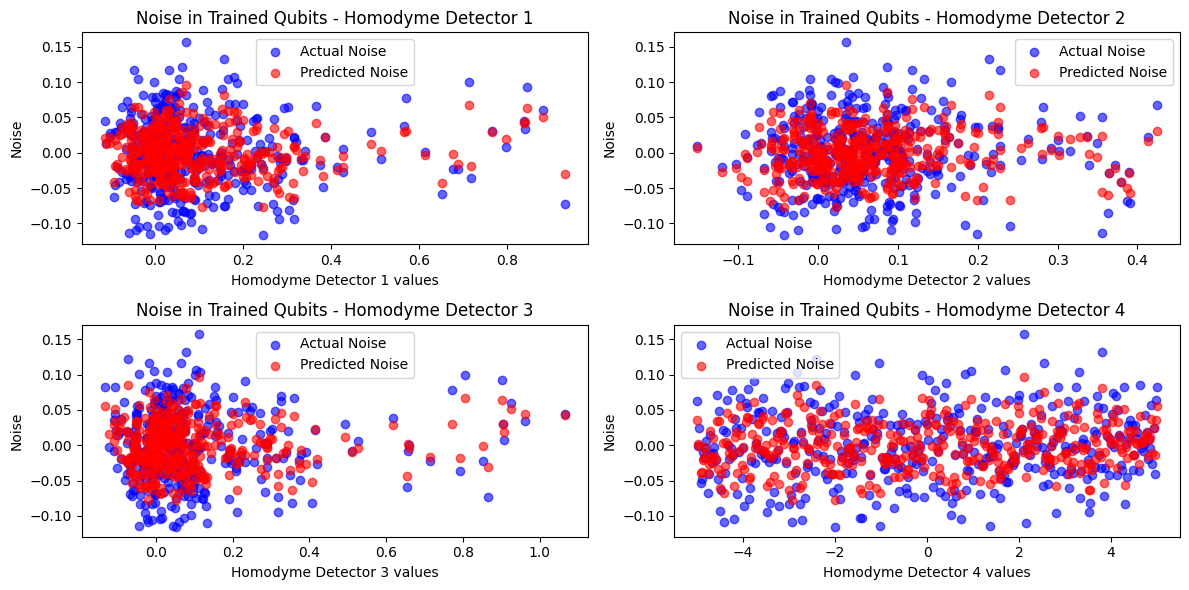

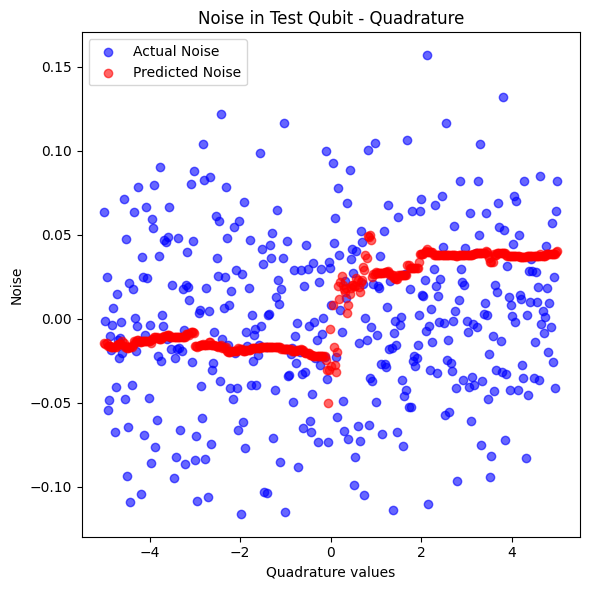

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the noise for the trained qubits (noisy)
y_train_pred = model.predict(X_train)

plt.figure(figsize=(12, 6))

# Plot for each feature in training data
for i, feature in enumerate(['Homodyme Detector 1', 'Homodyme Detector 2', 'Homodyme Detector 3', 'Homodyme Detector 4']):
    plt.subplot(2, 2, i+1)
    plt.scatter(df[feature], y_train, label='Actual Noise', color='blue', alpha=0.6)
    plt.scatter(df[feature], y_train_pred, label='Predicted Noise', color='red', alpha=0.6)
    plt.title(f'Noise in Trained Qubits - {feature}')
    plt.xlabel(f'{feature} values')
    plt.ylabel('Noise')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot the noise for the test qubit (clean qubit)
plt.figure(figsize=(6, 6))

plt.scatter(df['Homodyme Detector 4'], y_test, label='Actual Noise', color='blue', alpha=0.6)
plt.scatter(df['Homodyme Detector 4'], y_pred, label='Predicted Noise', color='red', alpha=0.6)
plt.title('Noise in Test Qubit - Quadrature')
plt.xlabel('Quadrature values')
plt.ylabel('Noise')
plt.legend()

plt.tight_layout()
plt.show()


In [97]:
import numpy as np
from strawberryfields import Engine, Program
from strawberryfields.ops import S2gate

M = 3
prog = Program(3)
eng = Engine("gaussian")

with prog.context as q:
    S2gate(0.1) | (q[1], q[2])

results = eng.run(prog)
state = results.state

In [63]:
p_fock11 = state.fock_prob([1, 1, 1])

In [64]:
mu = state.means()
cov = state.cov()

print(mu)
print(cov)

[0. 0. 0. 0. 0. 0.]
[[ 0.5         0.          0.          0.          0.          0.        ]
 [ 0.          0.51003338  0.100668    0.          0.          0.        ]
 [ 0.          0.100668    0.51003338  0.          0.          0.        ]
 [ 0.          0.          0.          0.5         0.          0.        ]
 [ 0.          0.          0.          0.          0.51003338 -0.100668  ]
 [ 0.          0.          0.          0.         -0.100668    0.51003338]]


In [65]:
from thewalrus import threshold_detection_prob

p_click11 = threshold_detection_prob(mu, cov, [1, 1, 0])

print(f"single-photon coincidence probability = {p_fock11}")
print(f"click coincidence probability = {np.real_if_close(p_click11)}")

single-photon coincidence probability = 0.0
click coincidence probability = 0.14586289490504786


In [68]:
prog = Program(3)
eng = Engine("gaussian")

with prog.context as q:
    S2gate(2) | (q[1], q[2])

results = eng.run(prog)
state = results.state

p_fock11 = state.fock_prob([1, 1,1])

mu = state.means()
cov = state.cov()

p_click11 = threshold_detection_prob(mu, cov, [1, 1, 0])

print(f"single-photon coincidence probability = {p_fock11}")
print(f"click coincidence probability = {p_click11.real}")

single-photon coincidence probability = 0.0
click coincidence probability = 0.0011947554955280023


In [61]:
from strawberryfields.ops import BSgate


def HOM_probs(r):

    prog = Program(3)
    eng = Engine("gaussian")

    with prog.context as q:
        S2gate(r) | (q[0], q[1])
        BSgate(0.25 * np.pi) | (q[0], q[1])

    results = eng.run(prog)
    state = results.state

    p_fock = state.fock_prob([1, 1, 0])

    mu = state.means()
    cov = state.cov()

    p_click = threshold_detection_prob(mu, cov, [1, 1, 0])

    return p_fock, p_click


r = 0.1
p_fock, p_click = HOM_probs(r)
print(f"squeezing: r = {r}")
print(f"single-photon coincidence probability = {np.round(p_fock,14)}")
print(f"threshold detector coincidence probability = {np.round(p_click.real, 14)}")


r = 1
p_fock, p_click = HOM_probs(r)
print()
print(f"squeezing: r = {r}")
print(f"single-photon coincidence probability = {np.round(p_fock,14)}")
print(f"threshold detector coincidence probability = {np.round(p_click.real, 14)}")

squeezing: r = 0.1
single-photon coincidence probability = 0.0
threshold detector coincidence probability = 0.14294467879665

squeezing: r = 1
single-photon coincidence probability = 0.0
threshold detector coincidence probability = 0.01516893869992


In [69]:
from strawberryfields.ops import Dgate

prog = Program(3)
eng = Engine("gaussian")

alpha = 1
r = 1

with prog.context as q:
    S2gate(r) | (q[0], q[1])
    Dgate(alpha) | q[2]
    BSgate(0.25 * np.pi) | (q[1], q[2])

results = eng.run(prog)
state = results.state

p_fock = state.fock_prob([1, 1, 1])

mu = state.means()
cov = state.cov()
print(mu)
print(cov)

p_click = threshold_detection_prob(mu, cov, [1, 1, 1])

print(f"single-photon coincidence probability = {np.round(p_fock,14)}")
print(f"threshold detector coincidence probability = {np.round(p_click.real, 14)}")

[ 0. -1.  1.  0.  0.  0.]
[[ 1.88109785  1.28228879  1.28228879  0.          0.          0.        ]
 [ 1.28228879  1.19054892  0.69054892  0.          0.          0.        ]
 [ 1.28228879  0.69054892  1.19054892  0.          0.          0.        ]
 [ 0.          0.          0.          1.88109785 -1.28228879 -1.28228879]
 [ 0.          0.          0.         -1.28228879  1.19054892  0.69054892]
 [ 0.          0.          0.         -1.28228879  0.69054892  1.19054892]]
single-photon coincidence probability = 0.0
threshold detector coincidence probability = 0.04027671552384


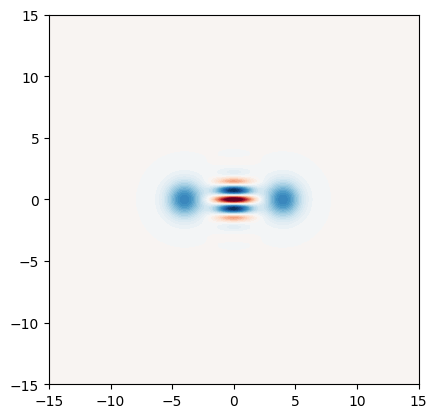

In [13]:
# Usual imports
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# Simulation and cat state parameters
nmodes = 1
cutoff = 30
q = 4.0
p = 0.0
hbar = 2
alpha = (q + 1j * p) / np.sqrt(2 * hbar)
k = 1

# SF program
prog_cat_fock = sf.Program(nmodes)
with prog_cat_fock.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff, "hbar": hbar})
state = eng.run(prog_cat_fock).state

# We now plot it
xvec = np.linspace(-15, 15, 401)
W = state.wigner(mode=0, xvec=xvec, pvec=xvec)
Wp = np.round(W.real, 4)
scale = np.max(Wp.real)
nrm = mpl.colors.Normalize(-scale, scale)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wp, 60, cmap=cm.RdBu, norm=nrm)
plt.show()


CSV Data:
      Qubit         X         Y         Z
0  Qubit 1  0.592404  0.328483  0.649276
1  Qubit 2  0.592404  0.328483  0.649276
2  Qubit 3  0.592404  0.328483  0.649276
3  Qubit 4 -0.199241 -0.031336 -0.245380
Length of t_taw_noise: 4
Length of t_plus1_noise: 4
Length of combined_noise: 4


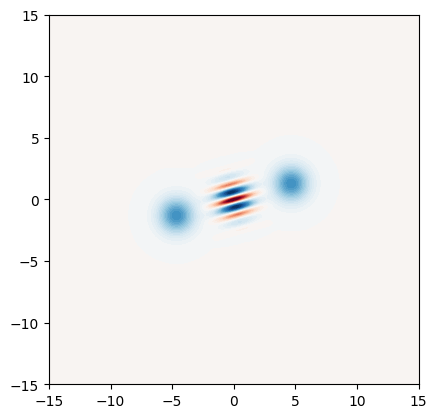

In [22]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import pandas as pd


file_path = '/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv'
try:

    noise_data = pd.read_csv(file_path, header=0, delimiter=',', engine='python')
    print("CSV Data:\n", noise_data.head())
except Exception as e:
    print(f"Error reading CSV file: {e}")

# Extract the columns representing noise (assuming second and third columns are `t-taw` and `t+1`)
# The first column is ignored as it contains non-numeric headers
t_taw_noise = noise_data['Y'].values  
t_plus1_noise = noise_data['Z'].values


#print("Length of t_taw_noise:", len(t_taw_noise))
#print("Length of t_plus1_noise:", len(t_plus1_noise))


if len(t_taw_noise) == 0 or len(t_plus1_noise) == 0:
    raise ValueError("Noise data is empty after.")

# Convert noise components to numpy arrays of float
t_taw_noise = np.array(t_taw_noise, dtype=float)
t_plus1_noise = np.array(t_plus1_noise, dtype=float)

# Create the complex noise by combining the two components
combined_noise = t_taw_noise + 1j * t_plus1_noise  

# Debug: Check the length of combined_noise array
print("Length of combined_noise:", len(combined_noise))


if len(combined_noise) == 0:
    raise ValueError("Combined noise array is empty. Check your data processing steps.")

# Initialize parameters
nmodes = 1
cutoff = 30
q = 4.0
p = 0.0
hbar = 2

# Apply the first noise value to alpha
alpha = (q + 1j * p) / np.sqrt(2 * hbar) + combined_noise[0]  

k = 1

# SF program
prog_cat_fock = sf.Program(nmodes)
with prog_cat_fock.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff, "hbar": hbar})
state = eng.run(prog_cat_fock).state


xvec = np.linspace(-15, 15, 401)
W = state.wigner(mode=0, xvec=xvec, pvec=xvec)
Wp = np.round(W.real, 4)
scale = np.max(Wp.real)
nrm = mpl.colors.Normalize(-scale, scale)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wp, 60, cmap=cm.RdBu, norm=nrm)
plt.show()


CSV Data:
      Qubit         X         Y         Z
0  Qubit 1  0.592404  0.328483  0.649276
1  Qubit 2  0.592404  0.328483  0.649276
2  Qubit 3  0.592404  0.328483  0.649276
3  Qubit 4 -0.199241 -0.031336 -0.245380
Length of t_taw_noise: 4
Length of t_plus1_noise: 4
Length of combined_noise: 4
Means: [[ 4.6569658 +0.j          1.29855122+0.j        ]
 [-4.6569658 +0.j         -1.29855122+0.j        ]
 [ 0.        +1.29855122j  0.        -4.6569658j ]
 [ 0.        -1.29855122j  0.        +4.6569658j ]]
Covariances: [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Weights: [ 5.00004202e-01+0.00000000e+00j  5.00004202e-01+0.00000000e+00j
 -4.20211892e-06-5.14611148e-22j -4.20211892e-06+5.14611148e-22j]
True


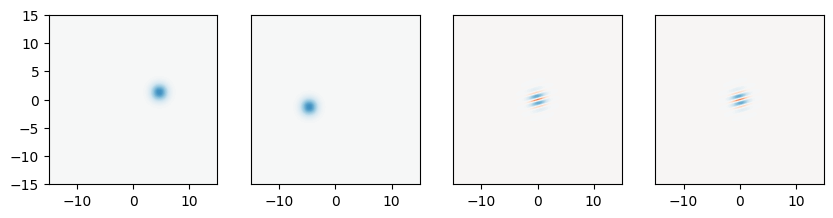

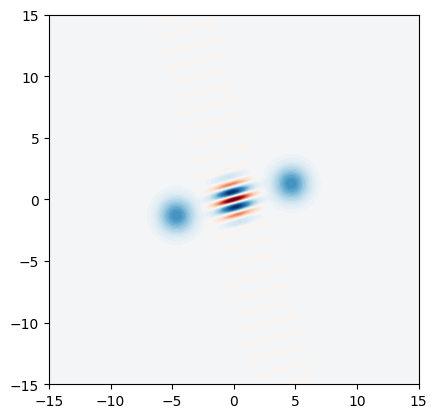

In [25]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import pandas as pd

# Load noise data from CSV, skipping the header row
file_path = '/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv'
try:
    # Read the CSV file, skipping the header
    noise_data = pd.read_csv(file_path, header=0, delimiter=',', engine='python')
    print("CSV Data:\n", noise_data.head())
except Exception as e:
    print(f"Error reading CSV file: {e}")

# Extract the columns representing noise (assuming second and third columns are `t-taw` and `t+1`)
t_taw_noise = noise_data['Y'].values  # Column `Y` for t-taw
t_plus1_noise = noise_data['Z'].values  # Column `Z` for t+1

# Debug: Check the length and content of noise arrays
print("Length of t_taw_noise:", len(t_taw_noise))
print("Length of t_plus1_noise:", len(t_plus1_noise))

# Ensure there is data available
if len(t_taw_noise) == 0 or len(t_plus1_noise) == 0:
    raise ValueError("Noise data is empty after cleaning. Check your CSV file.")

# Convert noise components to numpy arrays of float
t_taw_noise = np.array(t_taw_noise, dtype=float)
t_plus1_noise = np.array(t_plus1_noise, dtype=float)

# Create the complex noise by combining the two components
combined_noise = t_taw_noise + 1j * t_plus1_noise  # Element-wise complex noise

# Debug: Check the length of combined_noise array
print("Length of combined_noise:", len(combined_noise))

# Ensure combined_noise is not empty
if len(combined_noise) == 0:
    raise ValueError("Combined noise array is empty. Check your data processing steps.")

# Initialize other parameters
nmodes = 1
cutoff = 30
q = 4.0
p = 0.0
hbar = 2

# Apply the first noise value to alpha
alpha = (q + 1j * p) / np.sqrt(2 * hbar) + combined_noise[0]  # Adding the first noise value

k = 1

# SF program for cat state in bosonic mode
prog_cat_bosonic = sf.Program(nmodes)
with prog_cat_bosonic.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q

eng = sf.Engine("bosonic", backend_options={"hbar": hbar})
state = eng.run(prog_cat_bosonic).state

# Extract means, covariances, and weights
means = state.means()
print("Means:", means)

covs = state.covs()
print("Covariances:", covs)

weights = state.weights()
print("Weights:", weights)

def gaussian_func_gen(mu, V):
    """Generates a function that returns a normalized Gaussian specified
    by a vector of means and a covariance matrix."""
    Vi = np.linalg.inv(V)
    norm = 1.0 / np.sqrt(np.linalg.det(2 * np.pi * V))
    fun = lambda x: norm * np.exp(-0.5 * (x - mu) @ Vi @ (x - mu))
    return fun

def evaluate_fun(fun, xvec, yvec):
    """Evaluate a function over a 2D grid of points."""
    return np.array([[fun(np.array([x, y])) for x in xvec] for y in xvec])

# Generate Gaussian functions for each component
funs = [gaussian_func_gen(means[i], covs[i]) for i in range(len(means))]

# Compute the Wigner functions for each Gaussian component
Wps = [weights[i] * evaluate_fun(funs[i], xvec, xvec) for i in range(len(weights))]

# Verify zero imaginary part when summing Wigner functions
print(np.allclose(sum(Wps).imag, 0))

# Plot each Wigner function
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2))
for i in range(4):
    Wp = np.round(Wps[i].real, 4)
    axs[i].contourf(xvec, xvec, Wp, 60, cmap=cm.RdBu, norm=nrm)
    if i != 0:
        axs[i].set_yticks([])
plt.show()

# Sum of Wigner functions
Wcat = sum(Wps)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wcat.real, 60, cmap=cm.RdBu, norm=nrm)
plt.show()


CSV Data:
      Qubit         X         Y         Z
0  Qubit 1  0.592404  0.328483  0.649276
1  Qubit 2  0.592404  0.328483  0.649276
2  Qubit 3  0.592404  0.328483  0.649276
3  Qubit 4 -0.199241 -0.031336 -0.245380
Length of t_taw_noise: 4
Length of t_plus1_noise: 4
Length of combined_noise: 4


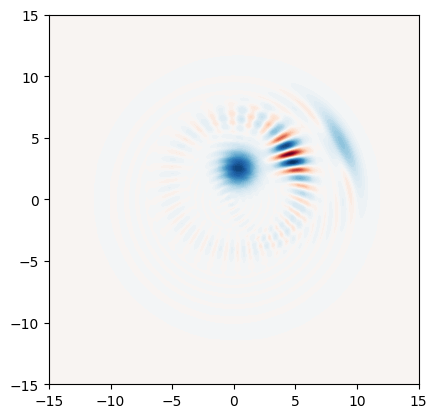

In [28]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import pandas as pd

# Load noise data from CSV, skipping the header row
file_path = '/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv'
try:
    # Read the CSV file, skipping the header
    noise_data = pd.read_csv(file_path, header=0, delimiter=',', engine='python')
    print("CSV Data:\n", noise_data.head())
except Exception as e:
    print(f"Error reading CSV file: {e}")

# Extract the columns representing noise (assuming second and third columns are `t-taw` and `t+1`)
t_taw_noise = noise_data['Y'].values  # Column `Y` for t-taw
t_plus1_noise = noise_data['Z'].values  # Column `Z` for t+1

# Debug: Check the length and content of noise arrays
print("Length of t_taw_noise:", len(t_taw_noise))
print("Length of t_plus1_noise:", len(t_plus1_noise))

# Ensure there is data available
if len(t_taw_noise) == 0 or len(t_plus1_noise) == 0:
    raise ValueError("Noise data is empty after cleaning. Check your CSV file.")

# Convert noise components to numpy arrays of float
t_taw_noise = np.array(t_taw_noise, dtype=float)
t_plus1_noise = np.array(t_plus1_noise, dtype=float)

# Create the complex noise by combining the two components
combined_noise = t_taw_noise + 1j * t_plus1_noise  # Element-wise complex noise

# Debug: Check the length of combined_noise array
print("Length of combined_noise:", len(combined_noise))

# Ensure combined_noise is not empty
if len(combined_noise) == 0:
    raise ValueError("Combined noise array is empty. Check your data processing steps.")

# Initialize other parameters
nmodes = 1
cutoff = 30
q = 4.0
p = 0.0
hbar = 2

# Apply the first noise value to alpha
alpha = (q + 1j * p) / np.sqrt(2 * hbar) + combined_noise[0]  # Adding the first noise value

# Define displacement parameters and apply noise
x = 6
y = 0
beta_real = (x + combined_noise[1].real) / np.sqrt(2 * hbar)  # Real part for r
beta_imag = y + combined_noise[1].imag  # Imaginary part for phi

k = 1

# SF program for displaced cat state
prog_cat_fock_displaced = sf.Program(nmodes)
with prog_cat_fock_displaced.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q
    sf.ops.Dgate(beta_real, beta_imag) | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff, "hbar": hbar})
state = eng.run(prog_cat_fock_displaced).state

# Plot the Wigner function of the returned state
xvec = np.linspace(-15, 15, 401)  # Define xvec as needed
W = state.wigner(mode=0, xvec=xvec, pvec=xvec)
Wp = np.round(W.real, 4)
scale = np.max(Wp.real)
nrm = mpl.colors.Normalize(-scale, scale)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wp, 60, cmap=cm.RdBu, norm=nrm)
plt.show()


CSV Data:
      Qubit         X         Y         Z
0  Qubit 1  0.592404  0.328483  0.649276
1  Qubit 2  0.592404  0.328483  0.649276
2  Qubit 3  0.592404  0.328483  0.649276
3  Qubit 4 -0.199241 -0.031336 -0.245380
Length of t_taw_noise: 4
Length of t_plus1_noise: 4
Length of combined_noise: 4


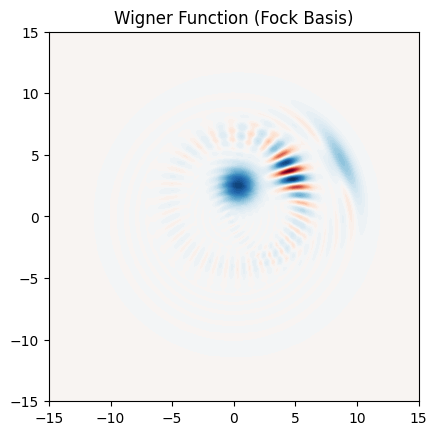

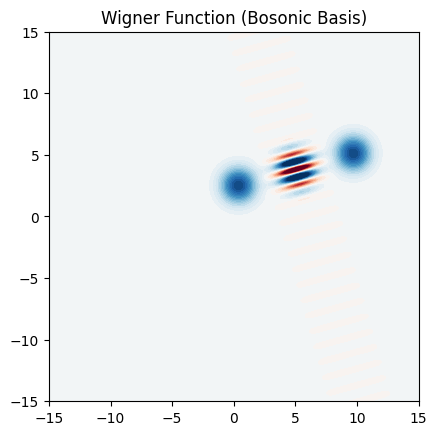

In [35]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import pandas as pd

# Load noise data from CSV, skipping the header row
file_path = '/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv'
try:
    # Read the CSV file, skipping the header
    noise_data = pd.read_csv(file_path, header=0, delimiter=',', engine='python')
    print("CSV Data:\n", noise_data.head())
except Exception as e:
    print(f"Error reading CSV file: {e}")

# Extract the columns representing noise (assuming second and third columns are `t-taw` and `t+1`)
t_taw_noise = noise_data['Y'].values  # Column `Y` for t-taw
t_plus1_noise = noise_data['Z'].values  # Column `Z` for t+1

# Debug: Check the length and content of noise arrays
print("Length of t_taw_noise:", len(t_taw_noise))
print("Length of t_plus1_noise:", len(t_plus1_noise))

# Ensure there is data available
if len(t_taw_noise) == 0 or len(t_plus1_noise) == 0:
    raise ValueError("Noise data is empty after cleaning. Check your CSV file.")

# Convert noise components to numpy arrays of float
t_taw_noise = np.array(t_taw_noise, dtype=float)
t_plus1_noise = np.array(t_plus1_noise, dtype=float)

# Create the complex noise by combining the two components
combined_noise = t_taw_noise + 1j * t_plus1_noise  # Element-wise complex noise

# Debug: Check the length of combined_noise array
print("Length of combined_noise:", len(combined_noise))

# Ensure combined_noise is not empty
if len(combined_noise) == 0:
    raise ValueError("Combined noise array is empty. Check your data processing steps.")

# Initialize parameters
nmodes = 1
cutoff = 30
q = 4.0
p = 0.0
hbar = 2

# Apply noise to alpha
alpha = (q + 1j * p) / np.sqrt(2 * hbar) + combined_noise[0]  # Adding the first noise value

# Define displacement parameters and apply noise
x = 6
y = 0
beta_real = (x + combined_noise[1].real) / np.sqrt(2 * hbar)  # Real part for r
beta_imag = y + combined_noise[1].imag  # Imaginary part for phi

k = 1

# SF program for displaced cat state in Fock basis
prog_cat_fock_displaced = sf.Program(nmodes)
with prog_cat_fock_displaced.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q
    sf.ops.Dgate(beta_real, beta_imag) | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff, "hbar": hbar})
state = eng.run(prog_cat_fock_displaced).state

# Plot the Wigner function of the returned state for Fock basis
xvec = np.linspace(-15, 15, 401)  # Define xvec as needed
W = state.wigner(mode=0, xvec=xvec, pvec=xvec)
Wp = np.round(W.real, 4)
scale = np.max(Wp.real)
nrm = mpl.colors.Normalize(-scale, scale)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wp, 60, cmap=cm.RdBu, norm=nrm)
plt.title("Wigner Function (Fock Basis)")
plt.show()

# SF program for displaced cat state in bosonic basis
prog_cat_bosonic_displaced = sf.Program(nmodes)
with prog_cat_bosonic_displaced.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q
    sf.ops.Dgate(beta_real, beta_imag) | q

eng = sf.Engine("bosonic", backend_options={"hbar": hbar})
state = eng.run(prog_cat_bosonic_displaced).state

# Compute Wigner function in the bosonic basis
Wps = state.wigner(mode=0, xvec=xvec, pvec=xvec)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wps, 60, cmap=cm.RdBu, norm=nrm)
plt.title("Wigner Function (Bosonic Basis)")
plt.show()


In [36]:
print(state.means())

[[9.69774155+0.j         5.12481254+0.j        ]
 [0.38380994+0.j         2.52771011+0.j        ]
 [5.04077574+1.29855122j 3.82626133-4.6569658j ]
 [5.04077574-1.29855122j 3.82626133+4.6569658j ]]


In [37]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [38]:


prog = sf.Program(1)
#We declare our quantum circuit using the engine. We can prepare the Vacuum state on one qumode using |.

with prog.context as q:
    Vac | q[0]

eng = sf.Engine('gaussian')
state = eng.run(prog).state

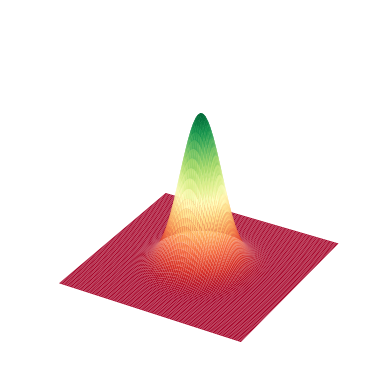

In [39]:
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

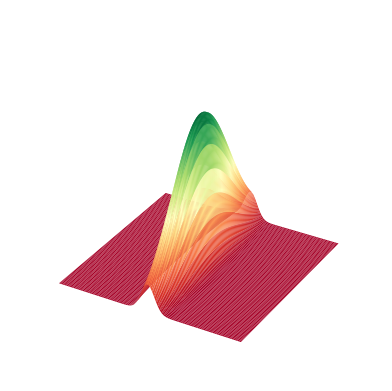

In [40]:
prog = sf.Program(1)
with prog.context as q:
    S = Sgate(1)
    S | q[0]


state = eng.run(prog).state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
fig.set_size_inches(4.8, 5)
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.set_axis_off()

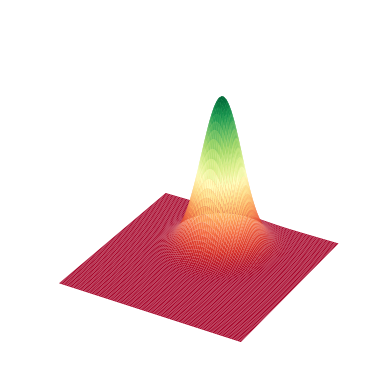

In [42]:
prog = sf.Program(1)
with prog.context as q:
    Dgate(1) | q[0]
    Rgate(np.pi/2) | q[0]

eng.reset()
state = eng.run(prog).state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

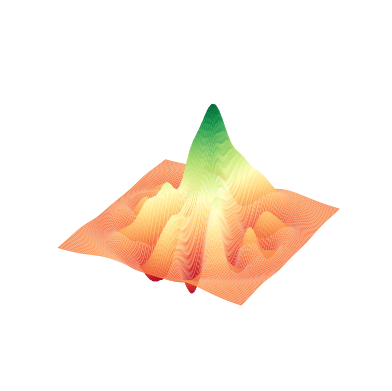

In [43]:
prog = sf.Program(1)
with prog.context as q:
    gamma = 2
    Vgate(gamma) | q[0]

#We use the fock backend and define the argument cutoff_dim
eng = sf.Engine('fock', backend_options={"cutoff_dim": 10})
state = eng.run(prog).state

fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

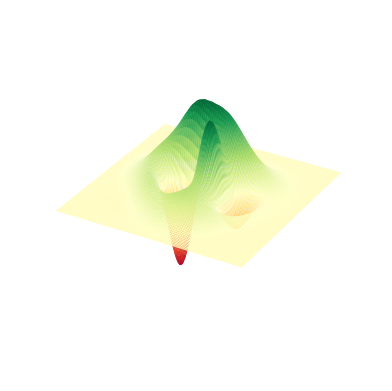

In [45]:
prog = sf.Program(1)
with prog.context as q:
    kappa = 1
    Dgate(1) | q[0]
    Kgate(kappa) | q[0]

eng.reset()
state = eng.run(prog).state

fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

CSV Data:
      Qubit         X         Y         Z
0  Qubit 1  0.592404  0.328483  0.649276
1  Qubit 2  0.592404  0.328483  0.649276
2  Qubit 3  0.592404  0.328483  0.649276
3  Qubit 4 -0.199241 -0.031336 -0.245380


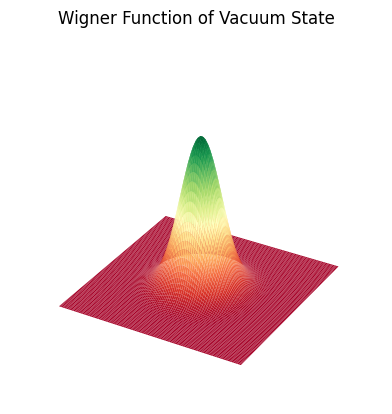

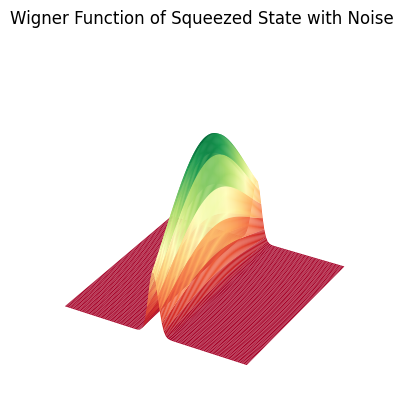

In [46]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Load noise data from CSV
file_path = '/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv'
try:
    noise_data = pd.read_csv(file_path, header=0, delimiter=',', engine='python')
    print("CSV Data:\n", noise_data.head())
except Exception as e:
    print(f"Error reading CSV file: {e}")

# Extract noise data (assuming the relevant columns are named 'X' and 'Y')
t_taw_noise = noise_data['Y'].values  # Column 'Y' for t-taw
t_plus1_noise = noise_data['Z'].values  # Column 'Z' for t+1

# Ensure there is data available
if len(t_taw_noise) == 0 or len(t_plus1_noise) == 0:
    raise ValueError("Noise data is empty after cleaning. Check your CSV file.")

# Convert noise components to numpy arrays of float
t_taw_noise = np.array(t_taw_noise, dtype=float)
t_plus1_noise = np.array(t_plus1_noise, dtype=float)

# Create the complex noise by combining the two components
combined_noise = t_taw_noise + 1j * t_plus1_noise  # Element-wise complex noise

# Initialize parameters
nmodes = 1
cutoff = 30
hbar = 2

# Apply noise to the vacuum state and squeezing gate
# Vacuum state has no parameters to adjust with noise

# Plotting the Vacuum State
prog_vacuum = sf.Program(nmodes)
with prog_vacuum.context as q:
    Vac | q[0]

eng = sf.Engine('gaussian')
state_vacuum = eng.run(prog_vacuum).state

# Plot the Wigner function of the vacuum state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state_vacuum.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()
plt.title("Wigner Function of Vacuum State")
plt.show()

# Apply noise to the squeezing gate
squeezing_strength = 1  # Default squeezing strength
noisy_squeezing_strength = squeezing_strength + t_taw_noise[0]  # Adding noise

# Squeezing State
prog_squeezing = sf.Program(nmodes)
with prog_squeezing.context as q:
    S = Sgate(noisy_squeezing_strength)
    S | q[0]

state_squeezing = eng.run(prog_squeezing).state

# Plot the Wigner function of the squeezed state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state_squeezing.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()
plt.title("Wigner Function of Squeezed State with Noise")
plt.show()


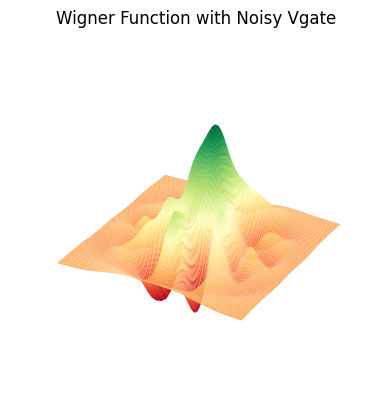

In [47]:


# Extract noise data (assuming the relevant columns are named 'X' and 'Y')
t_taw_noise = noise_data['Y'].values  # Column 'Y' for t-taw
t_plus1_noise = noise_data['Z'].values  # Column 'Z' for t+1

# Ensure there is data available
if len(t_taw_noise) == 0 or len(t_plus1_noise) == 0:
    raise ValueError("Noise data is empty after cleaning. Check your CSV file.")

# Convert noise components to numpy arrays of float
t_taw_noise = np.array(t_taw_noise, dtype=float)
t_plus1_noise = np.array(t_plus1_noise, dtype=float)

# Create the complex noise by combining the two components
combined_noise = t_taw_noise + 1j * t_plus1_noise  # Element-wise complex noise

# Initialize parameters
nmodes = 1
cutoff = 30
hbar = 2

# Apply noise to the Vgate
# Default gamma value
gamma = 2
# Add noise to gamma
noisy_gamma = gamma + t_taw_noise[0]  # Use the first noise value for simplicity

# Define and run the program with noisy Vgate
prog = sf.Program(1)
with prog.context as q:
    Vgate(noisy_gamma) | q[0]

# Use the fock backend and define the argument cutoff_dim
eng = sf.Engine('fock', backend_options={"cutoff_dim": 10})
state = eng.run(prog).state

# Plotting the Wigner function of the state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()
plt.title("Wigner Function with Noisy Vgate")
plt.show()


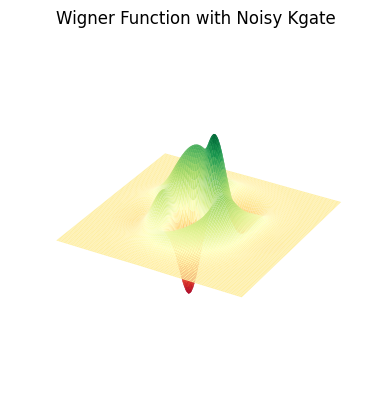

In [48]:


# Extract noise data (assuming the relevant columns are named 'X' and 'Y')
t_taw_noise = noise_data['Y'].values  # Column 'Y' for t-taw
t_plus1_noise = noise_data['Z'].values  # Column 'Z' for t+1

# Ensure there is data available
if len(t_taw_noise) == 0 or len(t_plus1_noise) == 0:
    raise ValueError("Noise data is empty after cleaning. Check your CSV file.")

# Convert noise components to numpy arrays of float
t_taw_noise = np.array(t_taw_noise, dtype=float)
t_plus1_noise = np.array(t_plus1_noise, dtype=float)

# Create the complex noise by combining the two components
combined_noise = t_taw_noise + 1j * t_plus1_noise  # Element-wise complex noise

# Initialize parameters
nmodes = 1
cutoff = 30
hbar = 2

# Apply noise to the Kgate
# Default kappa value
kappa = 1
# Add noise to kappa
noisy_kappa = kappa + t_taw_noise[0]  # Use the first noise value for simplicity

# Define and run the program with noisy Kgate
prog = sf.Program(1)
with prog.context as q:
    Dgate(1) | q[0]
    Kgate(noisy_kappa) | q[0]

# Use the fock backend and define the argument cutoff_dim
eng = sf.Engine('fock', backend_options={"cutoff_dim": 10})
state = eng.run(prog).state

# Plotting the Wigner function of the state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()
plt.title("Wigner Function with Noisy Kgate")
plt.show()


In [53]:
print("Length of noise data:", len(t_taw_noise))
print("Required noise length:", 3 * len(alpha))


Length of noise data: 4
Required noise length: 57


In [54]:
def apply_noise_to_parameters(alpha, phi, theta, noise):
    length = len(alpha)
    required_noise_length = 3 * length
    
    # Pad noise if it's shorter than needed
    if len(noise) < required_noise_length:
        padding_length = required_noise_length - len(noise)
        noise = np.concatenate([noise, np.zeros(padding_length)])
    
    noisy_alpha = np.array(alpha) + noise[:length]
    noisy_phi = np.array(phi) + noise[length:2*length]
    noisy_theta = np.array(theta) + noise[2*length:3*length]
    return noisy_alpha, noisy_phi, noisy_theta


In [55]:
# Example noise data
# Ensure t_taw_noise has sufficient length or use padding approach
noisy_alpha, noisy_phi, noisy_theta = apply_noise_to_parameters(alpha, phi, theta, t_taw_noise)

# Define and run the program with noisy parameters
prog0 = sf.Program(n)
with prog0.context as q:
    for i in range(n - 1):
        Sgate(r) | q[i + 1]
        BSgate(noisy_alpha[i]) | (q[i], q[i + 1])
        Rgate(noisy_phi[i]) | q[i + 1]
        MeasureHomodyne(noisy_theta[i]) | q[i]
eng0 = sf.Engine("gaussian")
result0 = eng0.run(prog0)

# Print the samples
print(result0.samples)


[[-0.07618789  0.63594373  0.05637652  0.53639488  0.4124308  -0.01721704
  -0.60807907 -0.14734038  0.15709065 -0.49081451 -0.06341304 -0.51050991
   0.05029604  0.14494223 -0.10254432  0.68479739 -0.38671114 -0.44743344
  -0.71973189]]


[[-0.22717241 -0.42371828]]
{0: [array([0.25549271]), array([-0.43675867]), array([-0.02465599]), array([0.19951079]), array([-1.04477946]), array([-0.15667574]), array([0.51421678]), array([0.23249896]), array([-0.01590816]), array([-0.22717241])], 1: [array([-0.07326049]), array([0.30536896]), array([0.1988064]), array([0.01149621]), array([-0.21612103]), array([-0.09278847]), array([-0.49293119]), array([-0.26040657]), array([-0.42371828])]}
{0: array([[ 0.25549271, -0.07326049, -0.43675867,  0.30536896, -0.02465599,
         0.1988064 ,  0.19951079,  0.01149621, -1.04477946, -0.21612103,
        -0.15667574, -0.09278847,  0.51421678, -0.49293119,  0.23249896,
        -0.26040657, -0.01590816, -0.42371828, -0.22717241]])}


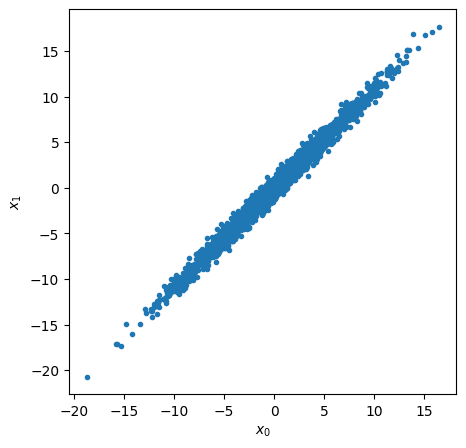

In [61]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, Rgate, MeasureHomodyne
import numpy as np
import matplotlib.pyplot as plt
from strawberryfields.tdm import shift_by, reshape_samples

# Define the function to apply noise with padding if necessary
def apply_noise_to_parameters(alpha, phi, theta, noise):
    length = len(alpha)
    required_noise_length = 3 * length

    # Check if noise data is sufficient
    if len(noise) < required_noise_length:
        # Pad noise data if it's not enough
        padding_length = required_noise_length - len(noise)
        noise = np.concatenate([noise, np.zeros(padding_length)])
    
    noisy_alpha = np.array(alpha) + noise[:length]
    noisy_phi = np.array(phi) + noise[length:2*length]
    noisy_theta = np.array(theta) + noise[2*length:3*length]
    
    return noisy_alpha, noisy_phi, noisy_theta

# Set parameters for the single-loop program
np.random.seed(42)  # Set the seed to facilitate comparison
n = 20  # Number of modes
r = 1.0  # Squeezing parameter

# Define parameters for EPR state generation
alpha = [np.pi / 4] * (n - 1)
phi = [0] * (n - 1)
theta = [0] * (n - 1)

# Generate or load noise data
t_taw_noise = np.random.normal(0, 0.1, size=3 * (n - 1))  # Ensure this has enough elements

# Apply noise to the parameters
noisy_alpha, noisy_phi, noisy_theta = apply_noise_to_parameters(alpha, phi, theta, t_taw_noise)

# Single-loop program with noise applied
prog1 = sf.Program(2)
with prog1.context as q:
    for i in range(n - 1):
        Sgate(r) | q[1]
        BSgate(noisy_alpha[i]) | (q[0], q[1])
        Rgate(noisy_phi[i]) | q[1]
        MeasureHomodyne(noisy_theta[i]) | q[0]
        q = shift_by(q, 1)
eng1 = sf.Engine("gaussian")
result1 = eng1.run(prog1)

# Print the samples and sample dictionary
print(result1.samples)
print(result1.samples_dict)

# Reshape the samples
reshaped_samples = reshape_samples(result1.samples_dict, [0], [2], n - 1)
print(reshaped_samples)

# Generate EPR states with noisy parameters
r = 2.0
alpha = [np.pi / 4, 0]
phi = [0, np.pi / 2]
theta = [0, 0]  # Measurement angles

# Apply noise to the EPR state parameters
noisy_alpha, noisy_phi, noisy_theta = apply_noise_to_parameters(alpha, phi, theta, t_taw_noise)

# Define the singleloop function
def singleloop(r, alpha, phi, theta, shots):
    """Single loop program.
    
    Args:
        r (float): squeezing parameter
        alpha (Sequence[float]): beamsplitter angles
        phi (Sequence[float]): rotation angles
        theta (Sequence[float]): homodyne measurement angles
        shots (int): number of times the circuit is sampled
    
    Returns:
        list: homodyne samples from the single loop simulation
    """
    prog = sf.TDMProgram(N=2)
    with prog.context(alpha, phi, theta) as (p, q):
        Sgate(r, 0) | q[1]
        BSgate(p[0]) | (q[0], q[1])
        Rgate(p[1]) | q[1]
        MeasureHomodyne(p[2]) | q[0]
    eng = sf.Engine("gaussian")
    result = eng.run(prog, shots=shots)
    # We only want the samples from concurrent mode 0
    return result.samples_dict[0]

# Generate EPR state samples
samplesEPRxx = singleloop(r, noisy_alpha, noisy_phi, noisy_theta, 2500)

# Process and plot the samples
samplesxx = samplesEPRxx.T
x0 = samplesxx[0]
x1 = samplesxx[1]

plt.figure(figsize=(5, 5))
plt.plot(x0, x1, ".")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_{1}$")
plt.show()


In [62]:
sample_var_xx = np.var(x0 - x1)
sample_var_xx

0.5425451480932001

In [63]:
expected_var_xx = 2 * np.exp(-2 * r)
expected_var_xx

0.03663127777746836

In [93]:
import numpy as np
from scipy.linalg import expm
import tensorflow as tf
import pandas as pd

import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.backends.tfbackend.ops import partial_trace

# Set the random seed
tf.random.set_seed(137)
np.random.seed(42)

# Load the noise data
noise_df = pd.read_csv('/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv')

# Print the first few rows and columns to understand the data
print(noise_df.head())
print("Columns in the CSV file:", noise_df.columns)

# Assuming the 'X' column contains the noise data
# Replace 'X' with the appropriate column name if necessary
if 'X' in noise_df.columns:
    noise_values = noise_df['X'].values
else:
    raise ValueError("Column 'X' not found. Please choose the appropriate column from: 'Qubit', 'X', 'Y', 'Z'.")

print("Noise values extracted:", noise_values)

# Set the Fock basis truncation
cutoff = 30

# Define the initial states
psi = np.zeros([cutoff], dtype=np.complex128)
psi[0] = 1.0
psi[1] = 1.0
psi /= np.linalg.norm(psi)

# Define the initial random guess for the second state
phi = np.random.random(size=[cutoff]) + 1j * np.random.random(size=[cutoff])
phi[10:] = 0.
phi /= np.linalg.norm(phi)

# Define the creation operator a
a = np.diag(np.sqrt(np.arange(1, cutoff)), k=1)
n_opt = a.T @ a

# Define quadrature operators
x = a + a.T
p = -1j * (a - a.T)

# Define the displacement function
def recenter(state):
    alpha = state.conj() @ a @ state
    disp_alpha = expm(alpha.conj() * a - alpha * a.T)
    out_state = disp_alpha @ state
    return out_state

# Center the states
psi = recenter(psi)
phi = recenter(phi)

# Print the displacement of the states before applying noise
print("Displacement of psi before noise:", psi.conj().T @ a @ psi)
print("Displacement of phi before noise:", phi.conj().T @ a @ phi)

# Apply noise to the states
def apply_noise(state, noise_values):
    noisy_state = state.copy()
    min_length = min(len(state), len(noise_values))
    noisy_state[:min_length] *= noise_values[:min_length]  # Apply noise as a scaling factor
    return noisy_state

# Apply noise to psi and phi
noisy_psi = apply_noise(psi, noise_values)
noisy_phi = apply_noise(phi, noise_values)

# Check the displacement of the noisy states
print("Displacement of noisy psi:", noisy_psi.conj().T @ a @ noisy_psi)
print("Displacement of noisy phi:", noisy_phi.conj().T @ a @ noisy_phi)


     Qubit         X         Y         Z
0  Qubit 1  0.592404  0.328483  0.649276
1  Qubit 2  0.592404  0.328483  0.649276
2  Qubit 3  0.592404  0.328483  0.649276
3  Qubit 4 -0.199241 -0.031336 -0.245380
Columns in the CSV file: Index(['Qubit', 'X', 'Y', 'Z'], dtype='object')
Noise values extracted: [ 0.59240403  0.59240403  0.59240403 -0.19924128]
Displacement of psi before noise: (8.326672684688674e-17+0j)
Displacement of phi before noise: (8.005196835509463e-08+1.1144807034888446e-08j)
Displacement of noisy psi: (0.03902642886480379+0j)
Displacement of noisy phi: (-0.11382500660338474+0.0679818048522178j)


In [96]:
penalty_strength = 10

prog = sf.Program(2)
eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff})

psi = tf.cast(psi, tf.complex64)
phi_var_re = tf.Variable(phi.real)
phi_var_im = tf.Variable(phi.imag)


with prog.context as q:
    Ket(prog.params("input_state")) | q
    BSgate(np.pi/4, 0) | q

In [97]:
def cost(phi_var_re, phi_var_im):
    phi_var = tf.cast(phi_var_re, tf.complex64) + 1j*tf.cast(phi_var_im, tf.complex64)

    in_state = tf.einsum('i,j->ij', psi, phi_var)

    result = eng.run(prog, args={"input_state": in_state}, modes=[1])
    state = result.state

    rhoB = state.dm()
    cost = tf.cast(tf.math.real((tf.linalg.trace(rhoB @ rhoB)
                                -penalty_strength*tf.linalg.trace(rhoB @ x)**2
                                -penalty_strength*tf.linalg.trace(rhoB @ p)**2)
                           /(tf.linalg.trace(rhoB))**2), tf.float64)

    return cost

In [98]:
opt = tf.keras.optimizers.Adam(learning_rate=0.007)

reps = 200

cost_progress = []

for i in range(reps):
    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        loss = -cost(phi_var_re, phi_var_im)

    # Stores cost at each step
    cost_progress.append(loss.numpy())

    # one repetition of the optimization
    gradients = tape.gradient(loss, [phi_var_re, phi_var_im])
    opt.apply_gradients(zip(gradients, [phi_var_re, phi_var_im]))

    # Prints progress
    if i % 1 == 0:
        print("Rep: {} Cost: {}".format(i, loss))

Rep: 0 Cost: -0.4766758680343628
Rep: 1 Cost: -0.4223328232765198
Rep: 2 Cost: -0.4963144361972809
Rep: 3 Cost: -0.45958492159843445
Rep: 4 Cost: -0.48182836174964905
Rep: 5 Cost: -0.5147172808647156
Rep: 6 Cost: -0.5162040591239929
Rep: 7 Cost: -0.5110471844673157
Rep: 8 Cost: -0.5209271311759949
Rep: 9 Cost: -0.5389845371246338
Rep: 10 Cost: -0.550225019454956
Rep: 11 Cost: -0.5520214438438416
Rep: 12 Cost: -0.5553421974182129
Rep: 13 Cost: -0.5651862025260925
Rep: 14 Cost: -0.5767858028411865
Rep: 15 Cost: -0.5858913064002991
Rep: 16 Cost: -0.5925741195678711
Rep: 17 Cost: -0.5986005663871765
Rep: 18 Cost: -0.605351448059082
Rep: 19 Cost: -0.6134762167930603
Rep: 20 Cost: -0.6225418448448181
Rep: 21 Cost: -0.6312930583953857
Rep: 22 Cost: -0.638716995716095
Rep: 23 Cost: -0.6450191140174866
Rep: 24 Cost: -0.6514298319816589
Rep: 25 Cost: -0.658822774887085
Rep: 26 Cost: -0.6668858528137207
Rep: 27 Cost: -0.6747289896011353
Rep: 28 Cost: -0.6818795204162598
Rep: 29 Cost: -0.688531816

In [99]:
ket_val = phi_var_re.numpy() + phi_var_im.numpy()*1j
out_rhoB = np.outer(ket_val, ket_val.conj())
out_rhoB /= np.trace(out_rhoB)

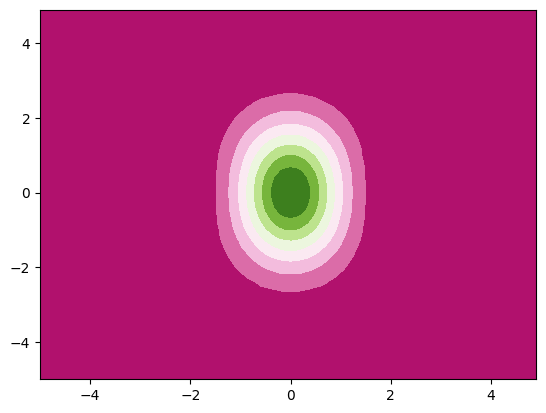

In [100]:
import copy
def wigner(rho, xvec, pvec):
    # Modified from qutip.org
    Q, P = np.meshgrid(xvec, pvec)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m)
                    * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

# Import plotting
from matplotlib import pyplot as plt
# %matplotlib inline

x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
X, P, W = wigner(out_rhoB, x, p)
plt.contourf(X, P, np.round(W,3), cmap="PiYG")
plt.show()


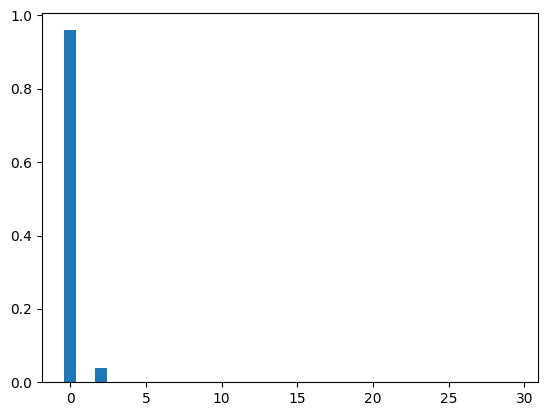

In [101]:
plt.bar(np.arange(cutoff), height=np.diag(out_rhoB).real)
plt.show()

In [102]:
nbar = np.trace(n_opt @ out_rhoB).real
print("mean number of photons =", nbar)
print("squeezing parameter =", np.arcsinh(np.sqrt(nbar)))

mean number of photons = 0.08352930377676059
squeezing parameter = 0.28513495831198626


Mean Squared Error: 0.0026
R-squared Score: -0.0790

First few predictions vs actual values:
Predicted: 0.0126, Actual: -0.0132
Predicted: 0.0054, Actual: 0.0310
Predicted: 0.0036, Actual: -0.0380
Predicted: -0.0008, Actual: -0.0310
Predicted: 0.0072, Actual: 0.0600


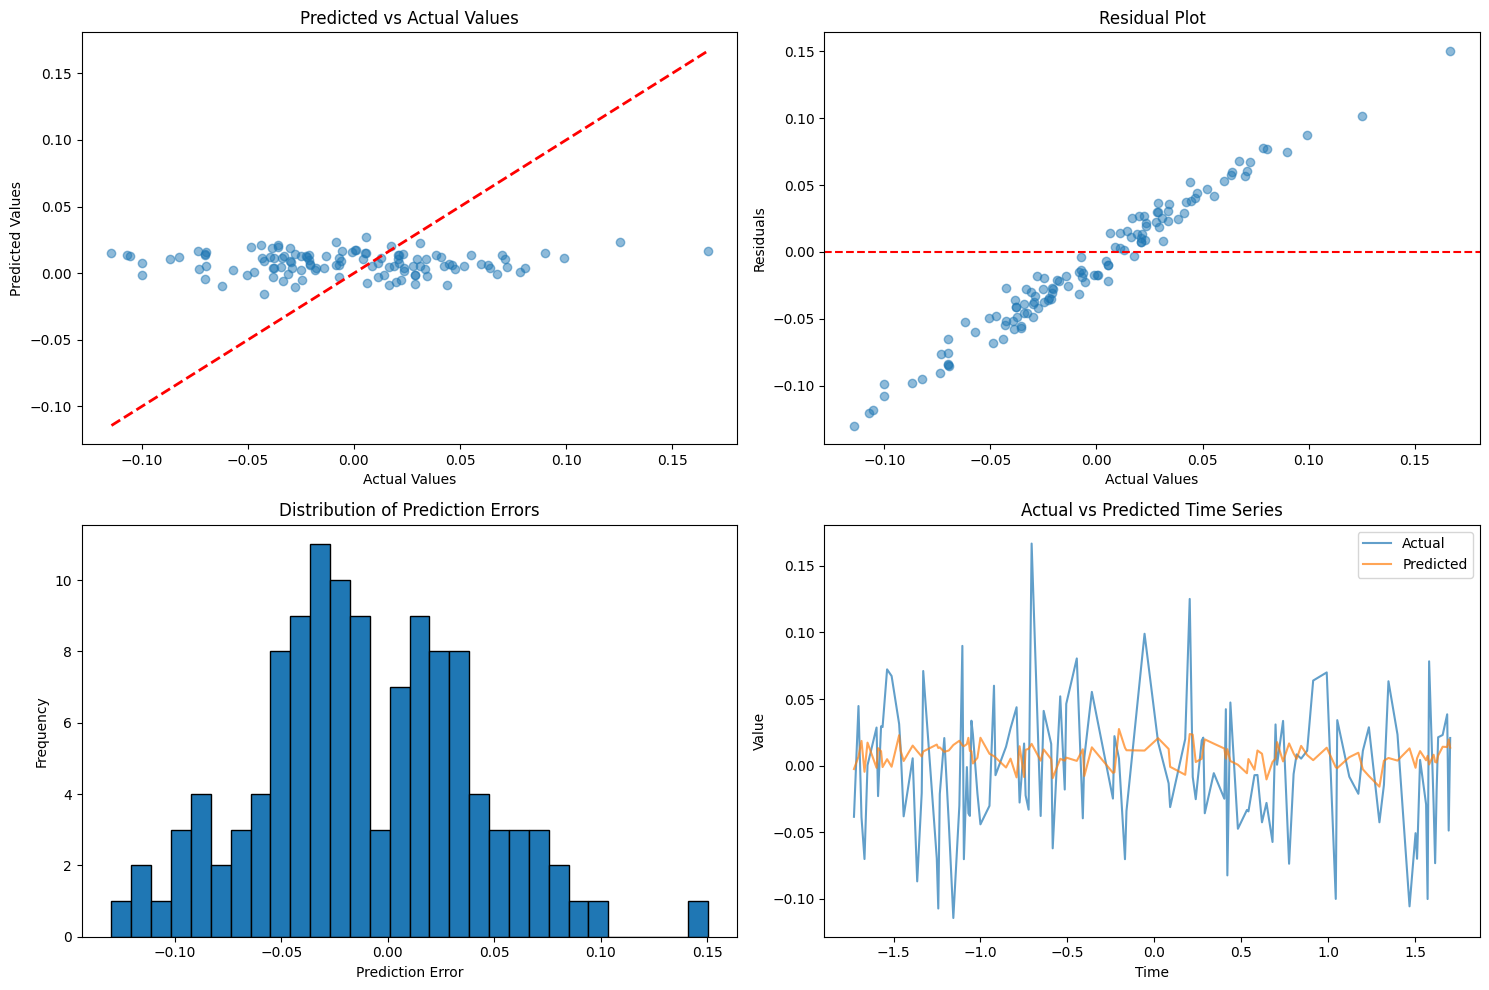

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from qiskit.circuit.library import ZZFeatureMap
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw1).csv', sep=',', header=0)

# Extract features (X) and target (y)
X = df[['Homodyme Detector 4', 'Homodyme Detector 1']].values
y = df['Random_Noise'].values

# Preprocess the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Set up the quantum feature map
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

# Set up the fidelity and quantum kernel
fidelity = ComputeUncompute(sampler=Sampler())
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

# Create the KernelRidge regressor with our quantum kernel
qkr = KernelRidge(kernel=quantum_kernel.evaluate)

# Train the model
qkr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_scaled = qkr.predict(X_test)

# Inverse transform the predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate and print the mean squared error
mse = mean_squared_error(y_test_original, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Calculate and print the R-squared score
r2 = r2_score(y_test_original, y_pred)
print(f"R-squared Score: {r2:.4f}")

# Print the first few predictions vs actual values
print("\nFirst few predictions vs actual values:")
for pred, actual in zip(y_pred[:5], y_test_original[:5]):
    print(f"Predicted: {pred:.4f}, Actual: {actual:.4f}")
# Plotting
plt.figure(figsize=(15, 10))

# Plot 1: Predicted vs Actual Values
plt.subplot(2, 2, 1)
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# Plot 2: Residuals
plt.subplot(2, 2, 2)
residuals = y_test_original - y_pred
plt.scatter(y_test_original, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Plot 3: Prediction Error Distribution
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

# Plot 4: Time Series of Actual vs Predicted
plt.subplot(2, 2, 4)
time_index = X_test[:, 0]  # Assuming the first feature is time
sorted_indices = np.argsort(time_index)
plt.plot(time_index[sorted_indices], y_test_original[sorted_indices], label='Actual', alpha=0.7)
plt.plot(time_index[sorted_indices], y_pred[sorted_indices], label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()

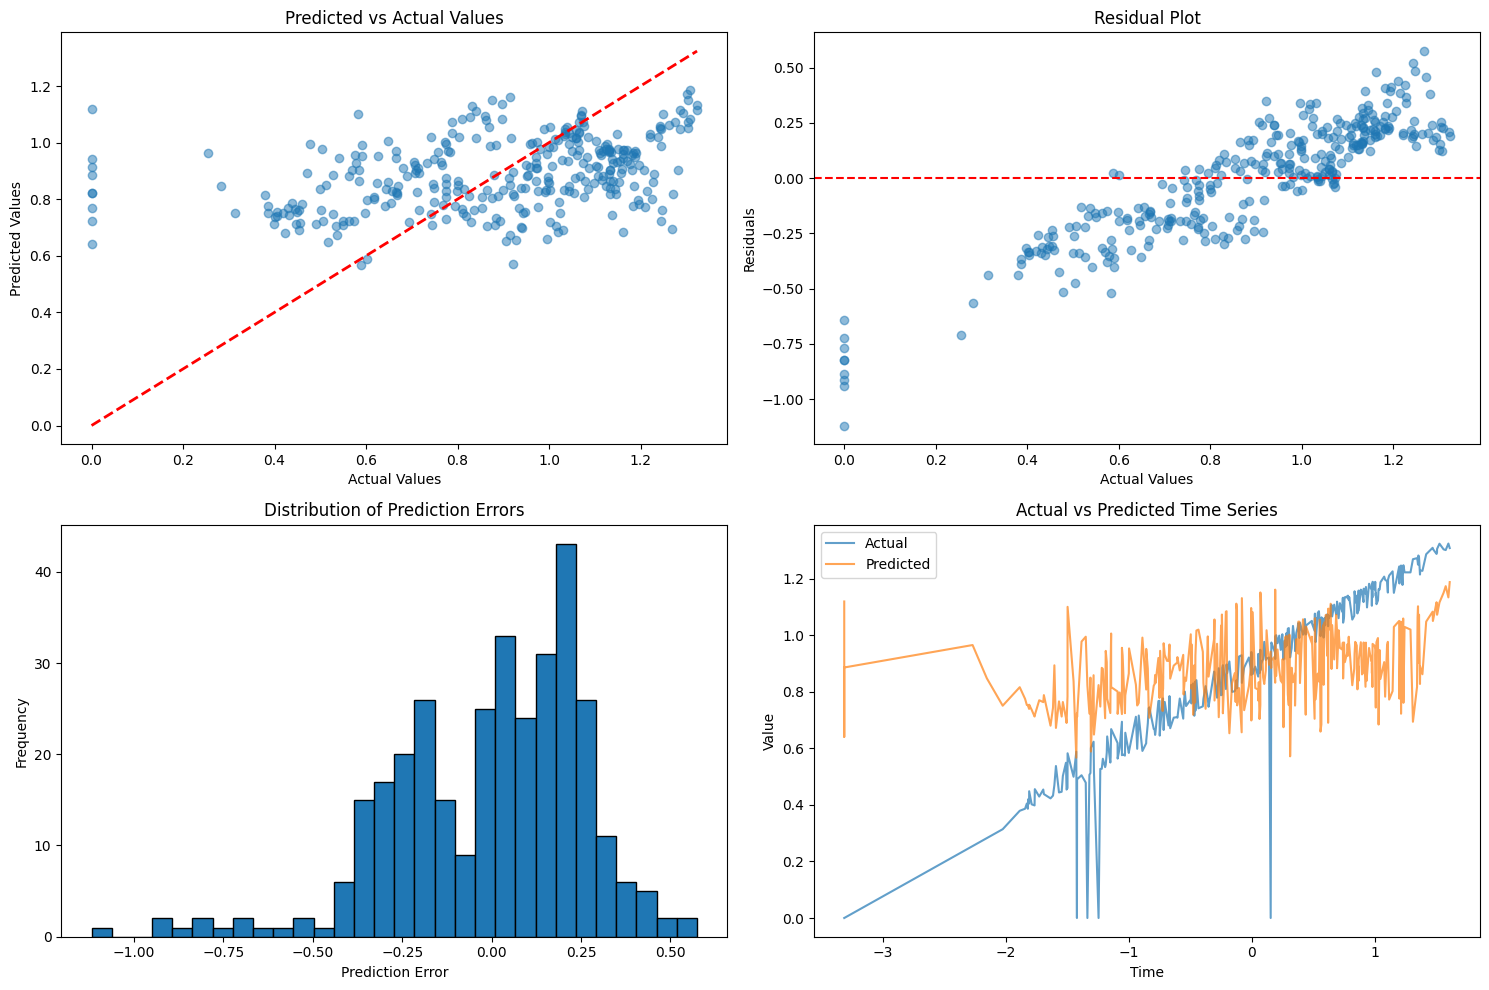

In [ ]:
# Plotting
plt.figure(figsize=(15, 10))

# Plot 1: Predicted vs Actual Values
plt.subplot(2, 2, 1)
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# Plot 2: Residuals
plt.subplot(2, 2, 2)
residuals = y_test_original - y_pred
plt.scatter(y_test_original, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Plot 3: Prediction Error Distribution
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

# Plot 4: Time Series of Actual vs Predicted
plt.subplot(2, 2, 4)
time_index = X_test[:, 0]  # Assuming the first feature is time
sorted_indices = np.argsort(time_index)
plt.plot(time_index[sorted_indices], y_test_original[sorted_indices], label='Actual', alpha=0.7)
plt.plot(time_index[sorted_indices], y_pred[sorted_indices], label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()

Quantum Kernel Ridge - MSE: 0.0717, R2: 0.1442
Random Forest - MSE: 0.0022, R2: 0.9740
SVR - MSE: 0.0012, R2: 0.9862


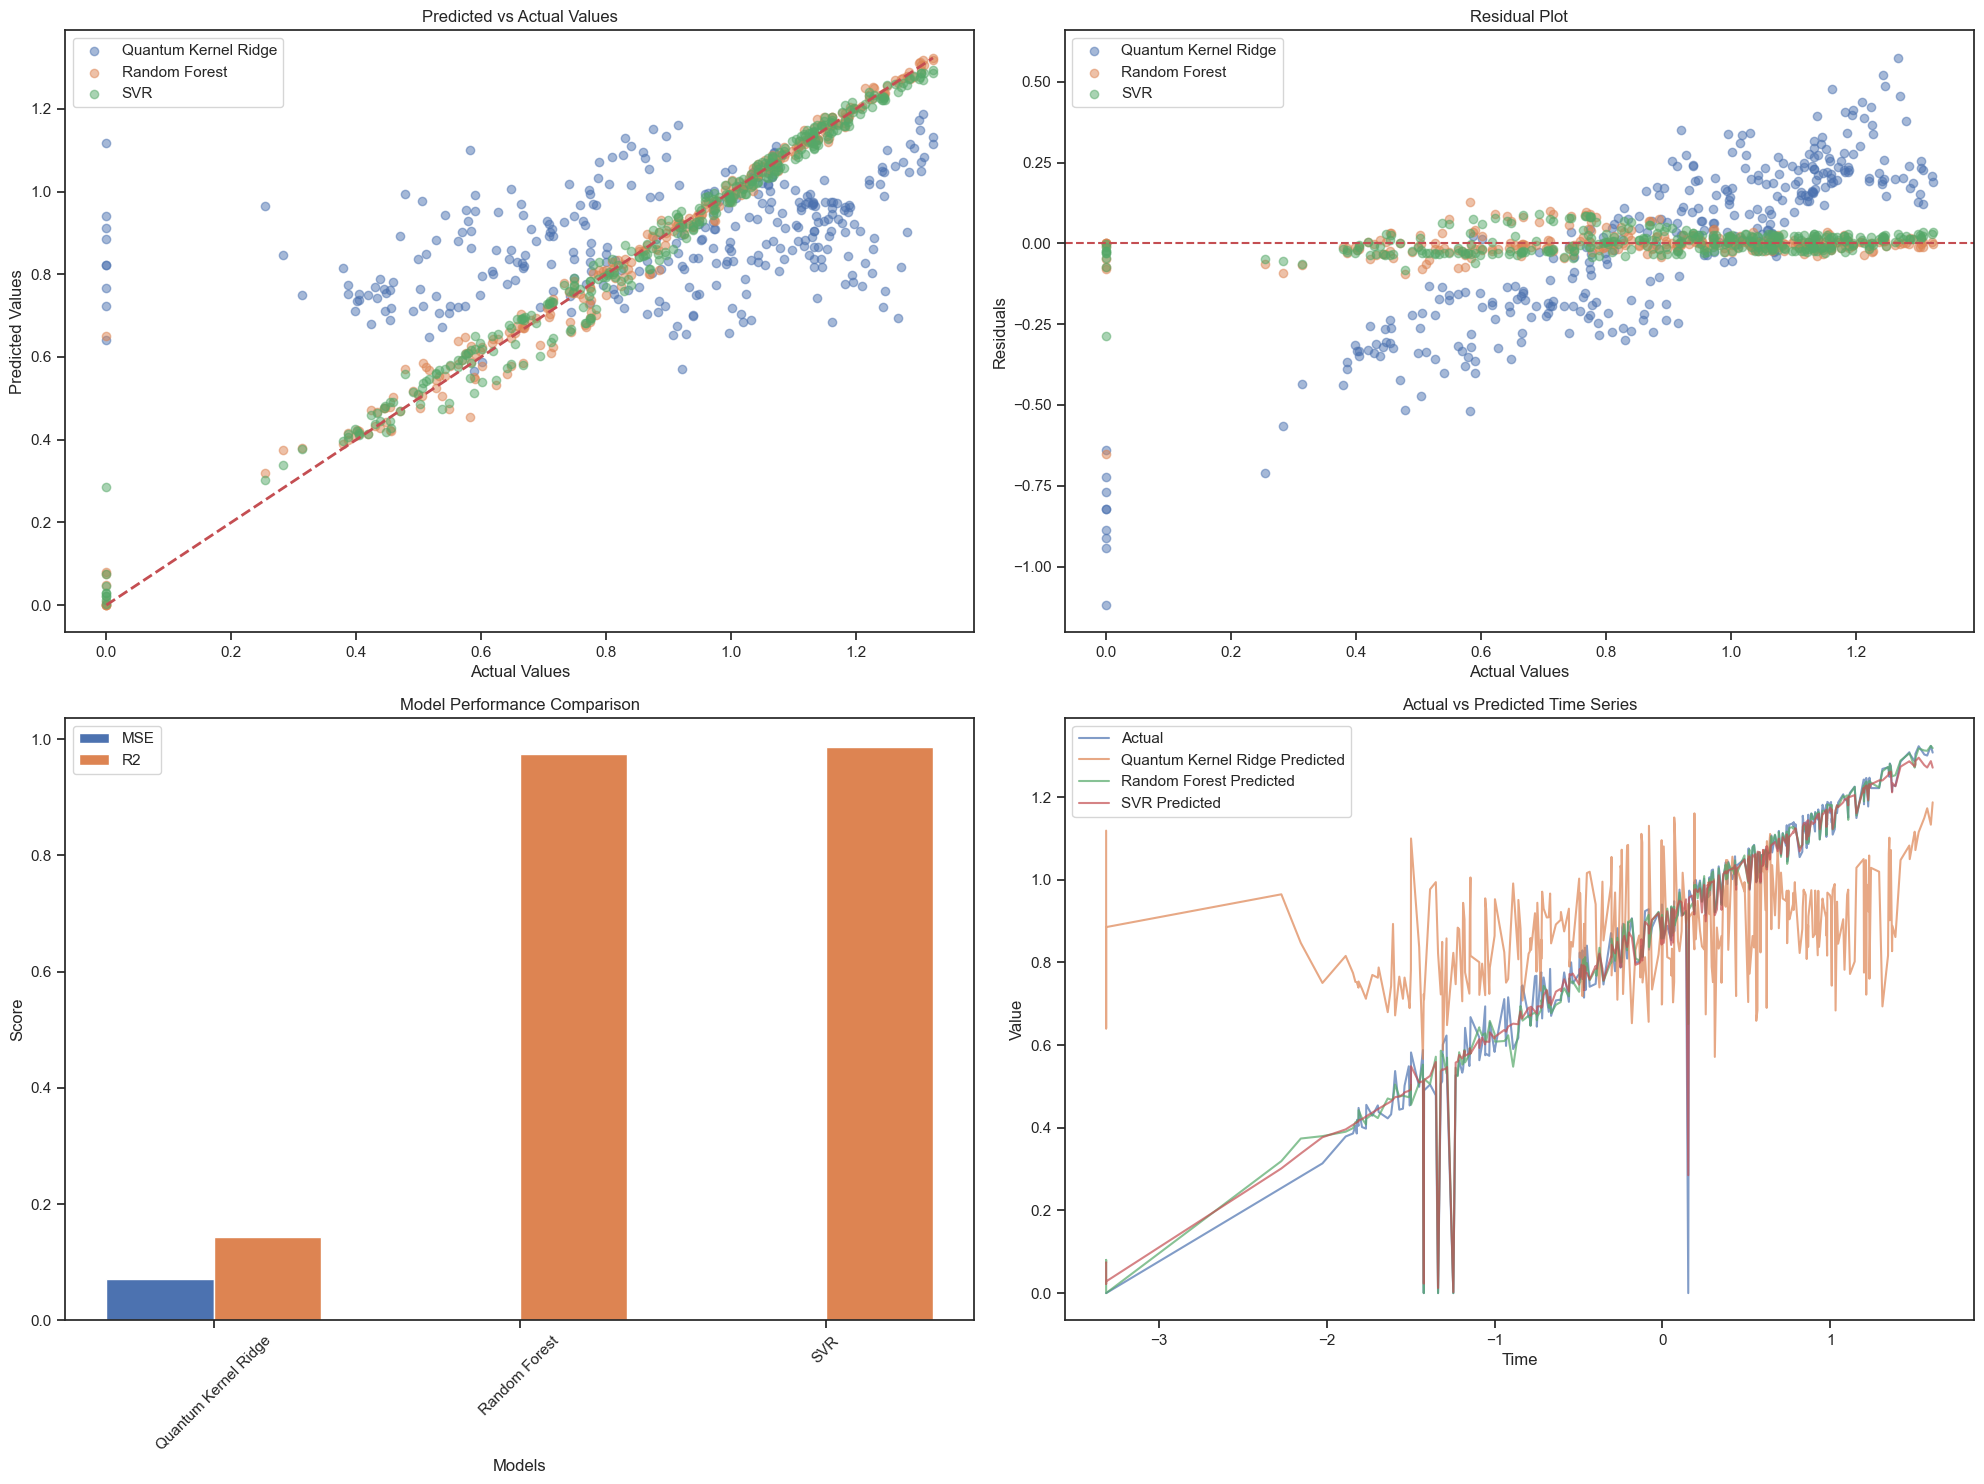

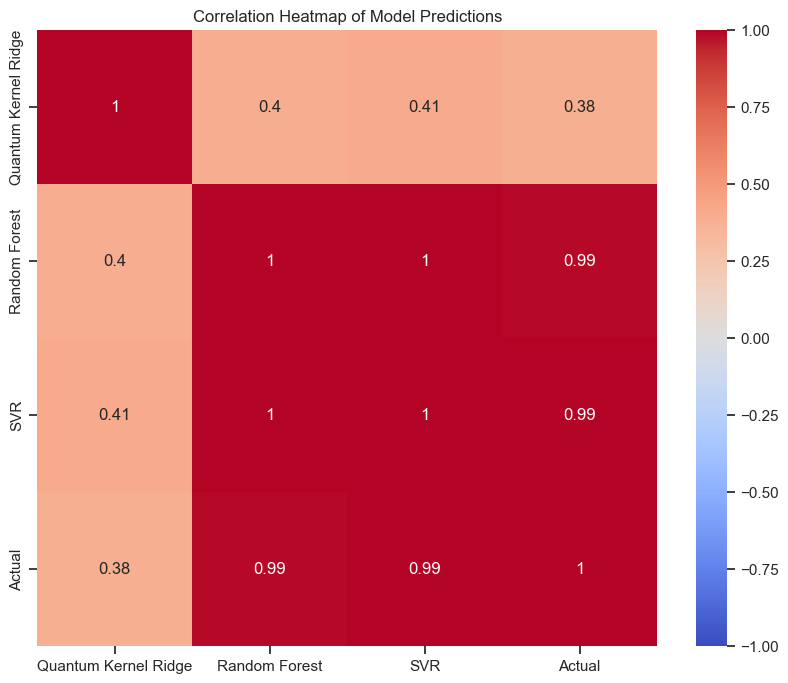

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from qiskit.circuit.library import ZZFeatureMap
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series.csv', sep=',', header=0)

# Extract features (X) and target (y)
X = df[['t', 't-taw']].values
y = df['t+1'].values

# Preprocess the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Set up the quantum feature map and kernel
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
fidelity = ComputeUncompute(sampler=Sampler())
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

# Create and train models
models = {
    'Quantum Kernel Ridge': KernelRidge(kernel=quantum_kernel.evaluate),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)
    results[name] = {'y_pred': y_pred, 'mse': mse, 'r2': r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

# Plotting
plt.figure(figsize=(20, 15))

# Plot 1: Predicted vs Actual Values
plt.subplot(2, 2, 1)
for name, res in results.items():
    plt.scatter(y_test_original, res['y_pred'], alpha=0.5, label=name)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()

# Plot 2: Residuals
plt.subplot(2, 2, 2)
for name, res in results.items():
    residuals = y_test_original - res['y_pred']
    plt.scatter(y_test_original, residuals, alpha=0.5, label=name)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()

# Plot 3: Model Performance Comparison
plt.subplot(2, 2, 3)
mse_values = [res['mse'] for res in results.values()]
r2_values = [res['r2'] for res in results.values()]
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, mse_values, width, label='MSE')
plt.bar(x + width/2, r2_values, width, label='R2')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()

# Plot 4: Time Series of Actual vs Predicted
plt.subplot(2, 2, 4)
time_index = X_test[:, 0]  # Assuming the first feature is time
sorted_indices = np.argsort(time_index)
plt.plot(time_index[sorted_indices], y_test_original[sorted_indices], label='Actual', alpha=0.7)
for name, res in results.items():
    plt.plot(time_index[sorted_indices], res['y_pred'][sorted_indices], label=f'{name} Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
pred_df = pd.DataFrame({name: res['y_pred'] for name, res in results.items()})
pred_df['Actual'] = y_test_original
corr_matrix = pred_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Model Predictions')
plt.show()

Random Forest - MSE: 1.3275, R2: -0.3250
SVR - MSE: 1.3225, R2: -0.3200


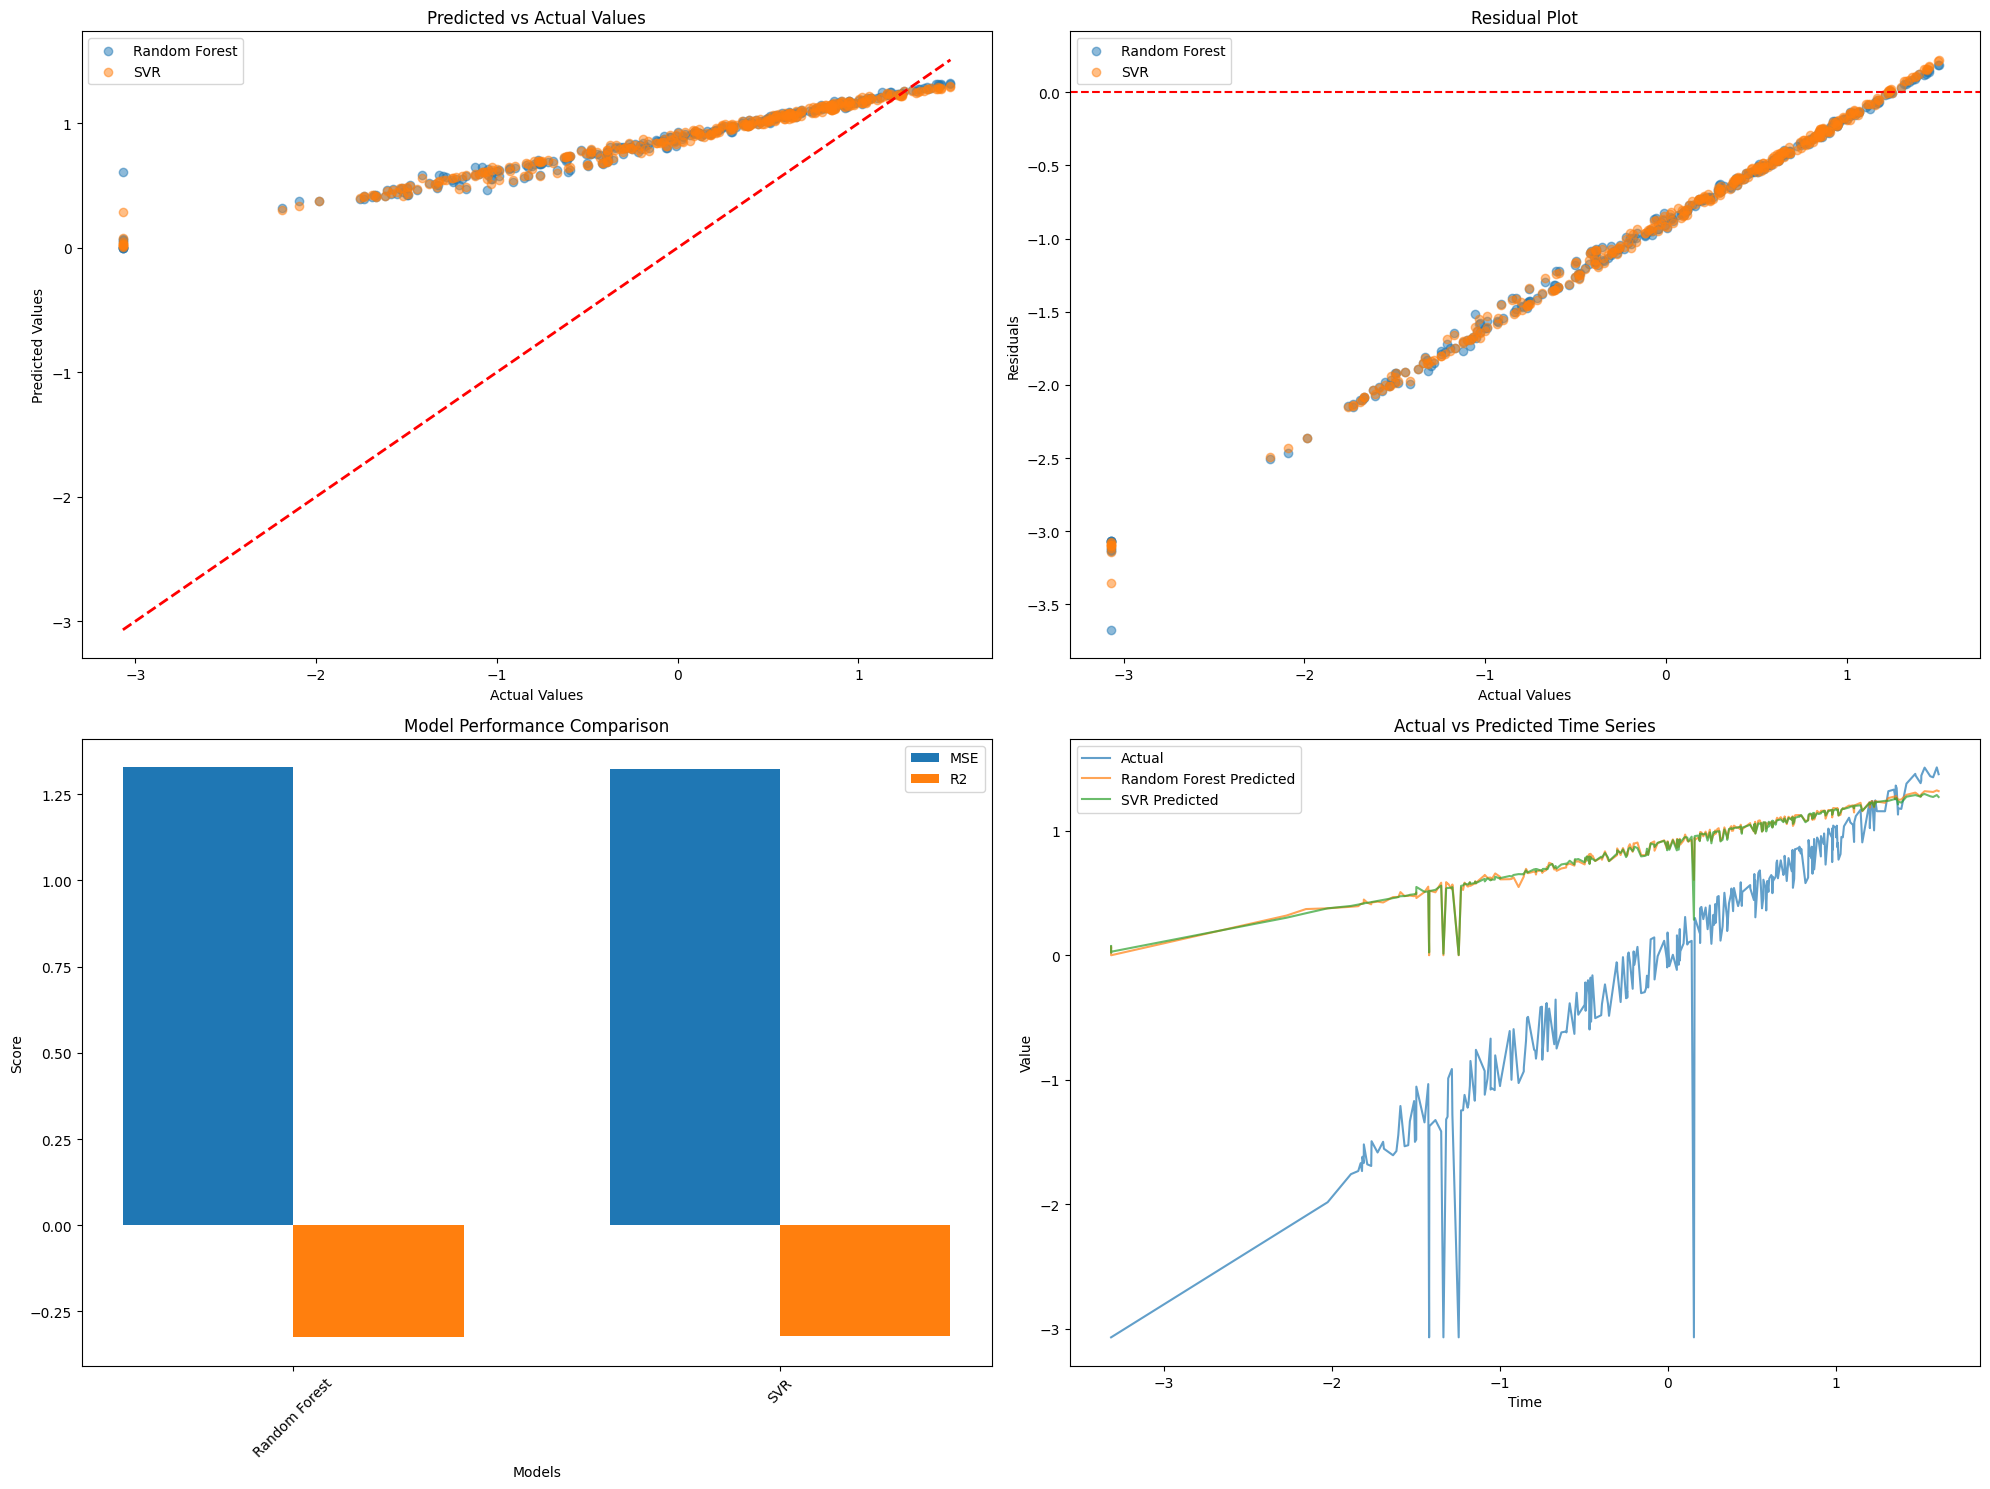

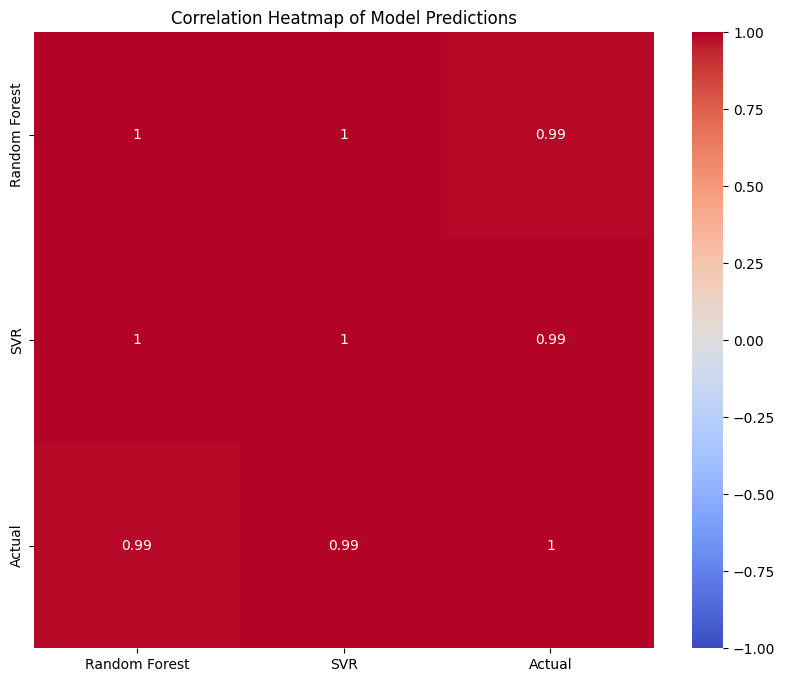

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from qiskit.circuit.library import ZZFeatureMap
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series.csv', sep=',', header=0)

# Extract features (X) and target (y)
X = df[['t', 't-taw']].values
y = df['t+1'].values

# Preprocess the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Set up the quantum feature map and kernel
feature_map = ZZFeatureMap(feature_dimension=2, reps=10)
fidelity = ComputeUncompute(sampler=Sampler())
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

# Create and train models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'SVR': SVR(kernel='rbf')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'y_pred': y_pred, 'mse': mse, 'r2': r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

# Plotting
plt.figure(figsize=(20, 15))

# Plot 1: Predicted vs Actual Values
plt.subplot(2, 2, 1)
for name, res in results.items():
    plt.scatter(y_test, res['y_pred'], alpha=0.5, label=name)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()

# Plot 2: Residuals
plt.subplot(2, 2, 2)
for name, res in results.items():
    residuals = y_test - res['y_pred']
    plt.scatter(y_test, residuals, alpha=0.5, label=name)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()

# Plot 3: Model Performance Comparison
plt.subplot(2, 2, 3)
mse_values = [res['mse'] for res in results.values()]
r2_values = [res['r2'] for res in results.values()]
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, mse_values, width, label='MSE')
plt.bar(x + width/2, r2_values, width, label='R2')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()

# Plot 4: Time Series of Actual vs Predicted
plt.subplot(2, 2, 4)
time_index = X_test[:, 0]  # Assuming the first feature is time
sorted_indices = np.argsort(time_index)
plt.plot(time_index[sorted_indices], y_test[sorted_indices], label='Actual', alpha=0.7)
for name, res in results.items():
    plt.plot(time_index[sorted_indices], res['y_pred'][sorted_indices], label=f'{name} Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
pred_df = pd.DataFrame({name: res['y_pred'] for name, res in results.items()})
pred_df['Actual'] = y_test
corr_matrix = pred_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Model Predictions')
plt.show()


ADAM-SGD - MSE: 0.0022, R2: 0.9740
VQE - MSE: 0.0012, R2: 0.9862


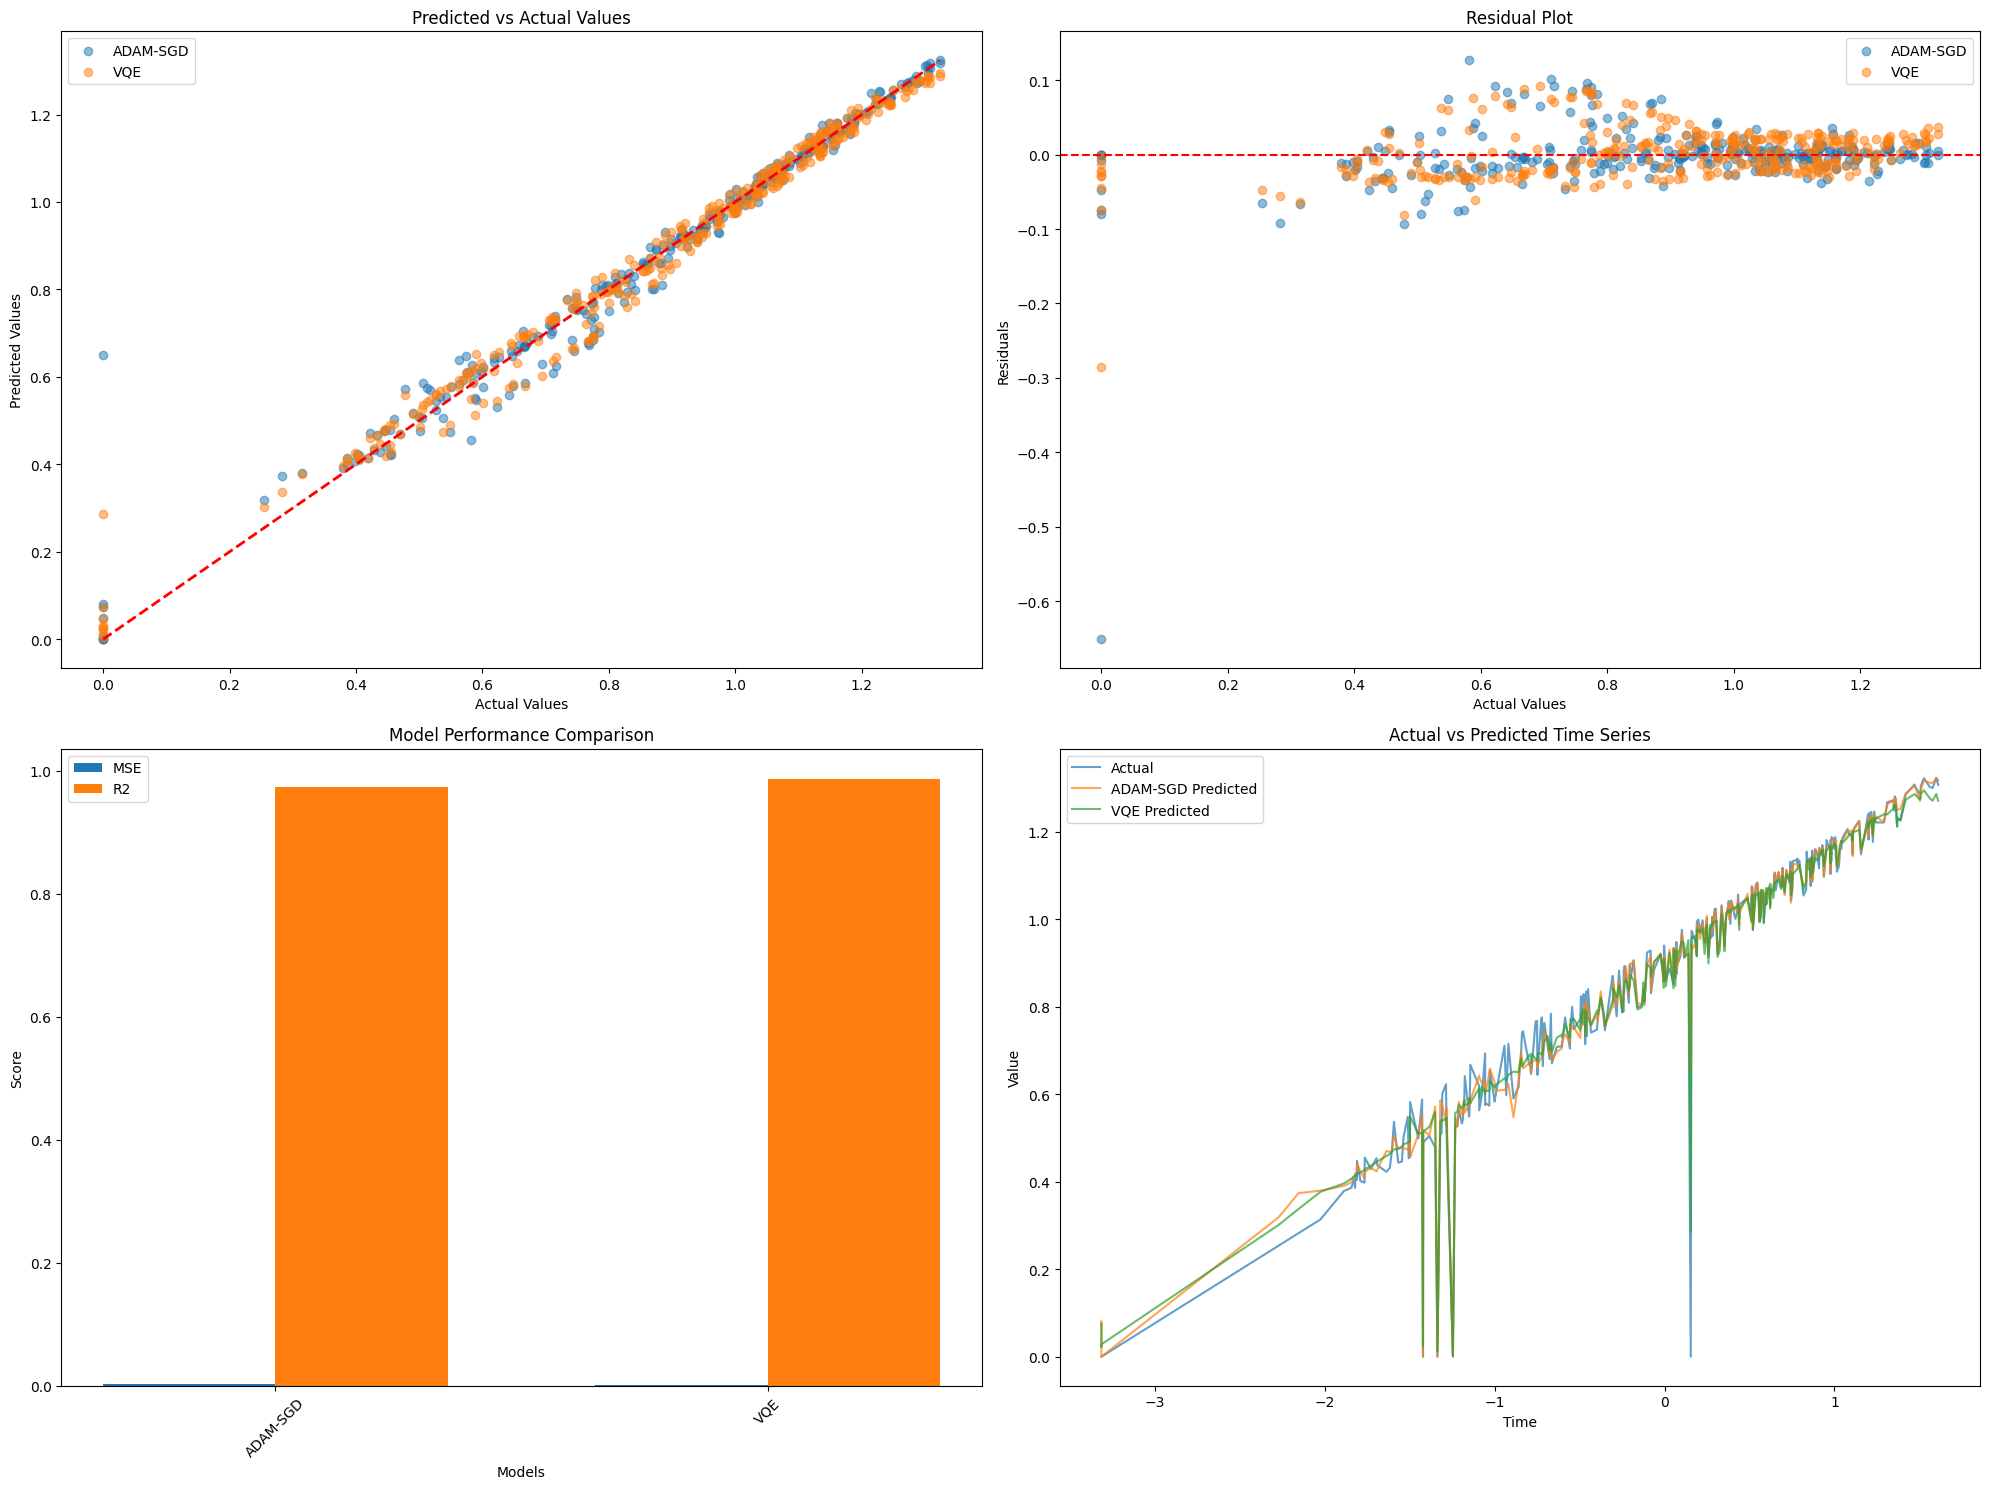

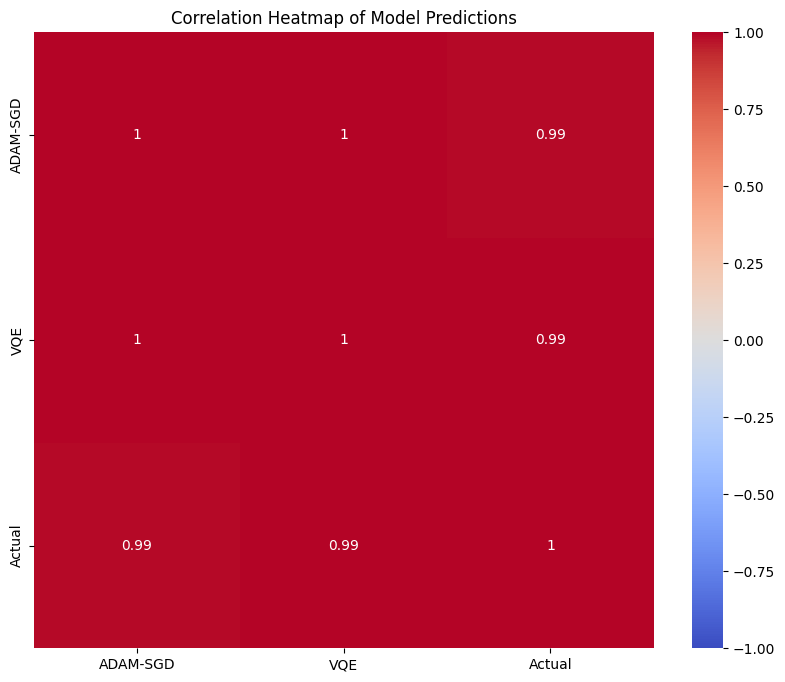

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series.csv', sep=',', header=0)

# Extract features (X) and target (y)
X = df[['t', 't-taw']].values
y = df['t+1'].values

# Preprocess the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Create and train models
models = {
    'ADAM-SGD': RandomForestRegressor(n_estimators=100, random_state=42),
    'VQE': SVR(kernel='rbf')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)
    results[name] = {'y_pred': y_pred, 'mse': mse, 'r2': r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

# Plotting
plt.figure(figsize=(20, 15))

# Plot 1: Predicted vs Actual Values
plt.subplot(2, 2, 1)
for name, res in results.items():
    plt.scatter(y_test_original, res['y_pred'], alpha=0.5, label=name)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()

# Plot 2: Residuals
plt.subplot(2, 2, 2)
for name, res in results.items():
    residuals = y_test_original - res['y_pred']
    plt.scatter(y_test_original, residuals, alpha=0.5, label=name)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()

# Plot 3: Model Performance Comparison
plt.subplot(2, 2, 3)
mse_values = [res['mse'] for res in results.values()]
r2_values = [res['r2'] for res in results.values()]
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, mse_values, width, label='MSE')
plt.bar(x + width/2, r2_values, width, label='R2')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()

# Plot 4: Time Series of Actual vs Predicted
plt.subplot(2, 2, 4)
time_index = X_test[:, 0]  # Assuming the first feature is time
sorted_indices = np.argsort(time_index)
plt.plot(time_index[sorted_indices], y_test_original[sorted_indices], label='Actual', alpha=0.7)
for name, res in results.items():
    plt.plot(time_index[sorted_indices], res['y_pred'][sorted_indices], label=f'{name} Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
pred_df = pd.DataFrame({name: res['y_pred'] for name, res in results.items()})
pred_df['Actual'] = y_test_original
corr_matrix = pred_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Model Predictions')
plt.show()

Random Forest - MSE: 0.0039, R2: -0.3154
SVR - MSE: 0.0032, R2: -0.0881


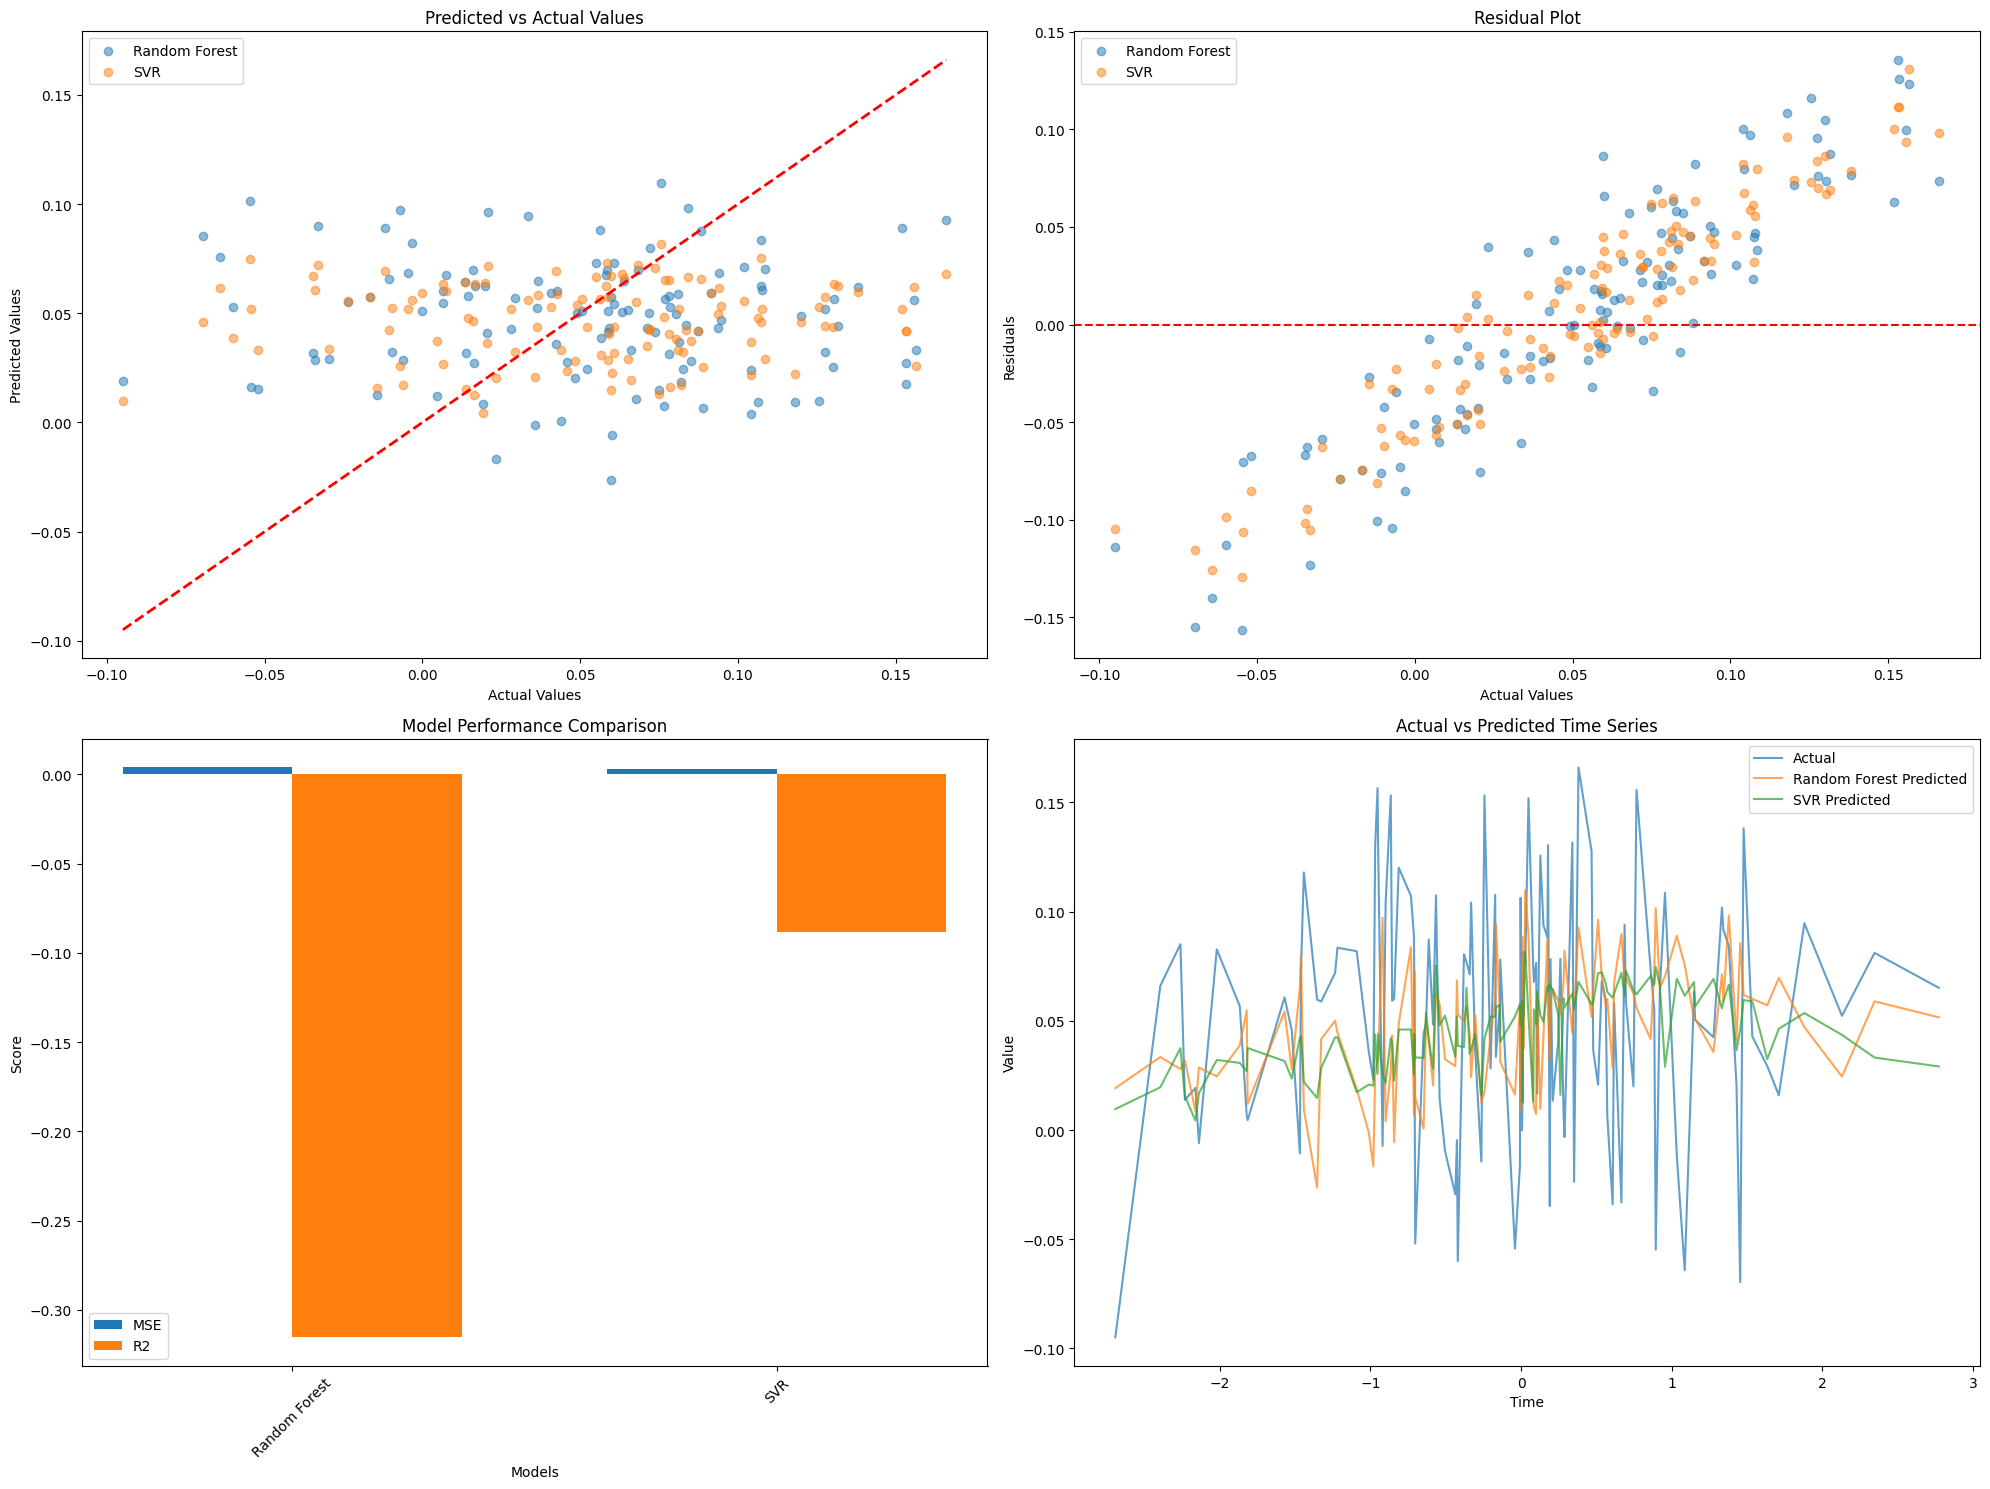

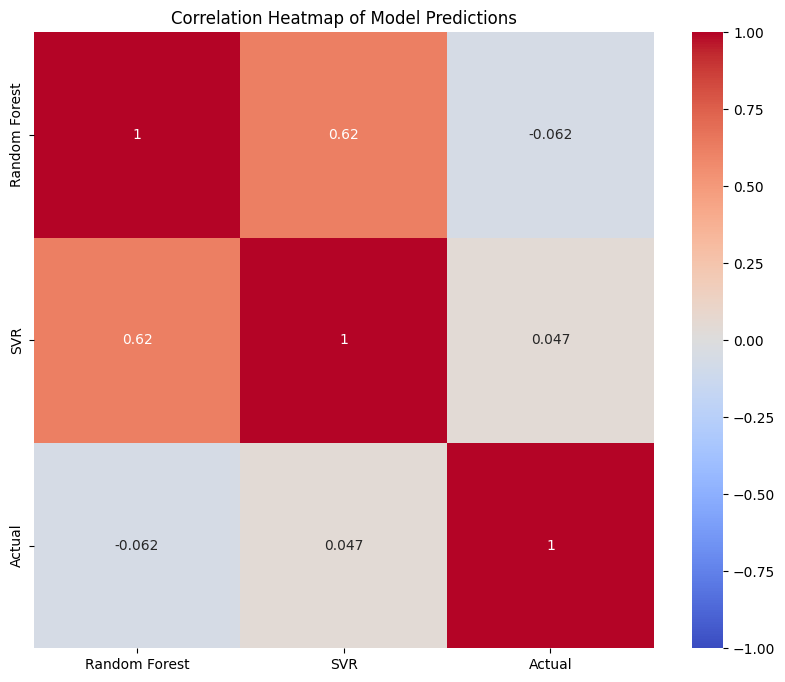

In [ ]:

df = pd.read_csv('/Users/shreyupadhyay/Downloads/Mackey-Glass Time Series(taw17).csv', sep=',', header=0)

# Extract features (X) and target (y)
X = df[['Homodyme Detector 1', 'Homodyme Detector 2']][:1000]
y = df['Homodyme Detector 3'].values[:1000]

# Preprocess the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Define y_test_original for later use
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Create and train models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)
    results[name] = {'y_pred': y_pred, 'mse': mse, 'r2': r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

# Plotting
plt.figure(figsize=(20, 15))

# Plot 1: Predicted vs Actual Values
plt.subplot(2, 2, 1)
for name, res in results.items():
    plt.scatter(y_test_original, res['y_pred'], alpha=0.5, label=name)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()

# Plot 2: Residuals
plt.subplot(2, 2, 2)
for name, res in results.items():
    residuals = y_test_original - res['y_pred']
    plt.scatter(y_test_original, residuals, alpha=0.5, label=name)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()

# Plot 3: Model Performance Comparison
plt.subplot(2, 2, 3)
mse_values = [res['mse'] for res in results.values()]
r2_values = [res['r2'] for res in results.values()]
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, mse_values, width, label='MSE')
plt.bar(x + width/2, r2_values, width, label='R2')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()

# Plot 4: Time Series of Actual vs Predicted
plt.subplot(2, 2, 4)
time_index = X_test[:, 0]  # Assuming the first feature is time
sorted_indices = np.argsort(time_index)
plt.plot(time_index[sorted_indices], y_test_original[sorted_indices], label='Actual', alpha=0.7)
for name, res in results.items():
    plt.plot(time_index[sorted_indices], res['y_pred'][sorted_indices], label=f'{name} Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
pred_df = pd.DataFrame({name: res['y_pred'] for name, res in results.items()})
pred_df['Actual'] = y_test_original
corr_matrix = pred_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Model Predictions')
plt.show()


Mean Squared Error: 54.571665844715255
R^2 Score: 0.026322048385836183


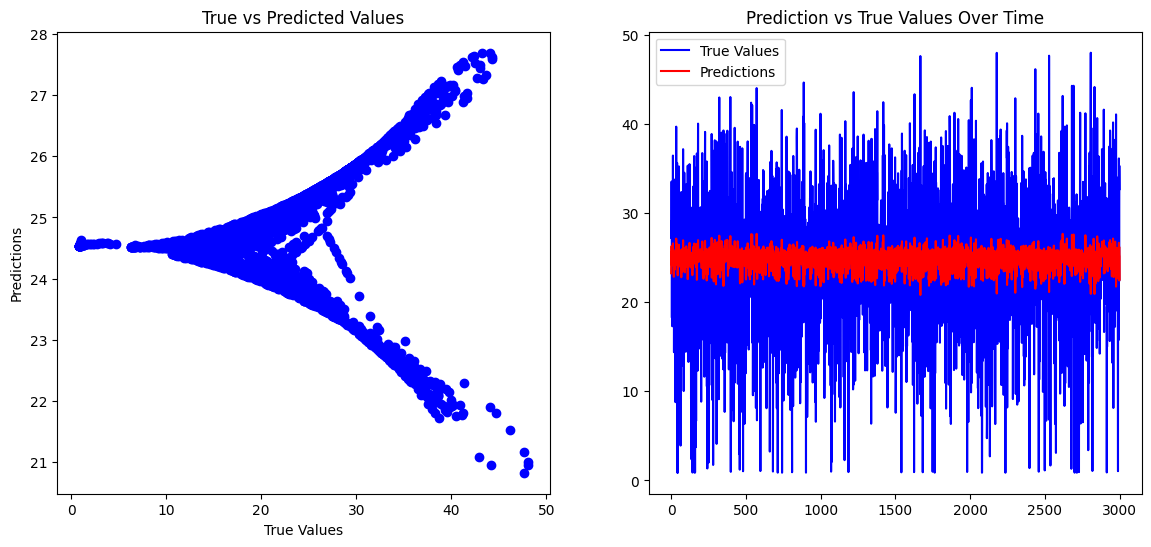

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Generate the Lorenz attractor dataset
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

# Initial conditions and time points
initial_state = [0., 1., 1.05]
t = np.linspace(0, 25, 10000)  # time points

# Solve the system of differential equations
sol = solve_ivp(lorenz, (t[0], t[-1]), initial_state, t_eval=t)

# Extracting the solutions
x = sol.y[0]
y = sol.y[1]
z = sol.y[2]

# Combine into a dataset
data = np.column_stack((x, y, z))

# Step 2: Split the dataset into 70% training and 30% testing
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Use x and y to predict z (as an example)
X_train = train_data[:, :2]
y_train = train_data[:, 2]

X_test = test_data[:, :2]
y_test = test_data[:, 2]

# Step 3: Train a Machine Learning Model (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Test the Model
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plotting the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")

plt.subplot(1, 2, 2)
plt.plot(y_test, color='blue', label='True Values')
plt.plot(y_pred, color='red', label='Predictions')
plt.legend()
plt.title("Prediction vs True Values Over Time")

plt.show()


Optimized Mean Squared Error: 2.9483058846537196
Optimized R^2 Score: 0.9473957704961719


/var/folders/z3/5wtht_qx4ylbrx748h07ps780000gn/T/ipykernel_14367/768744033.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["X", "Y"], y=importance, palette="viridis")


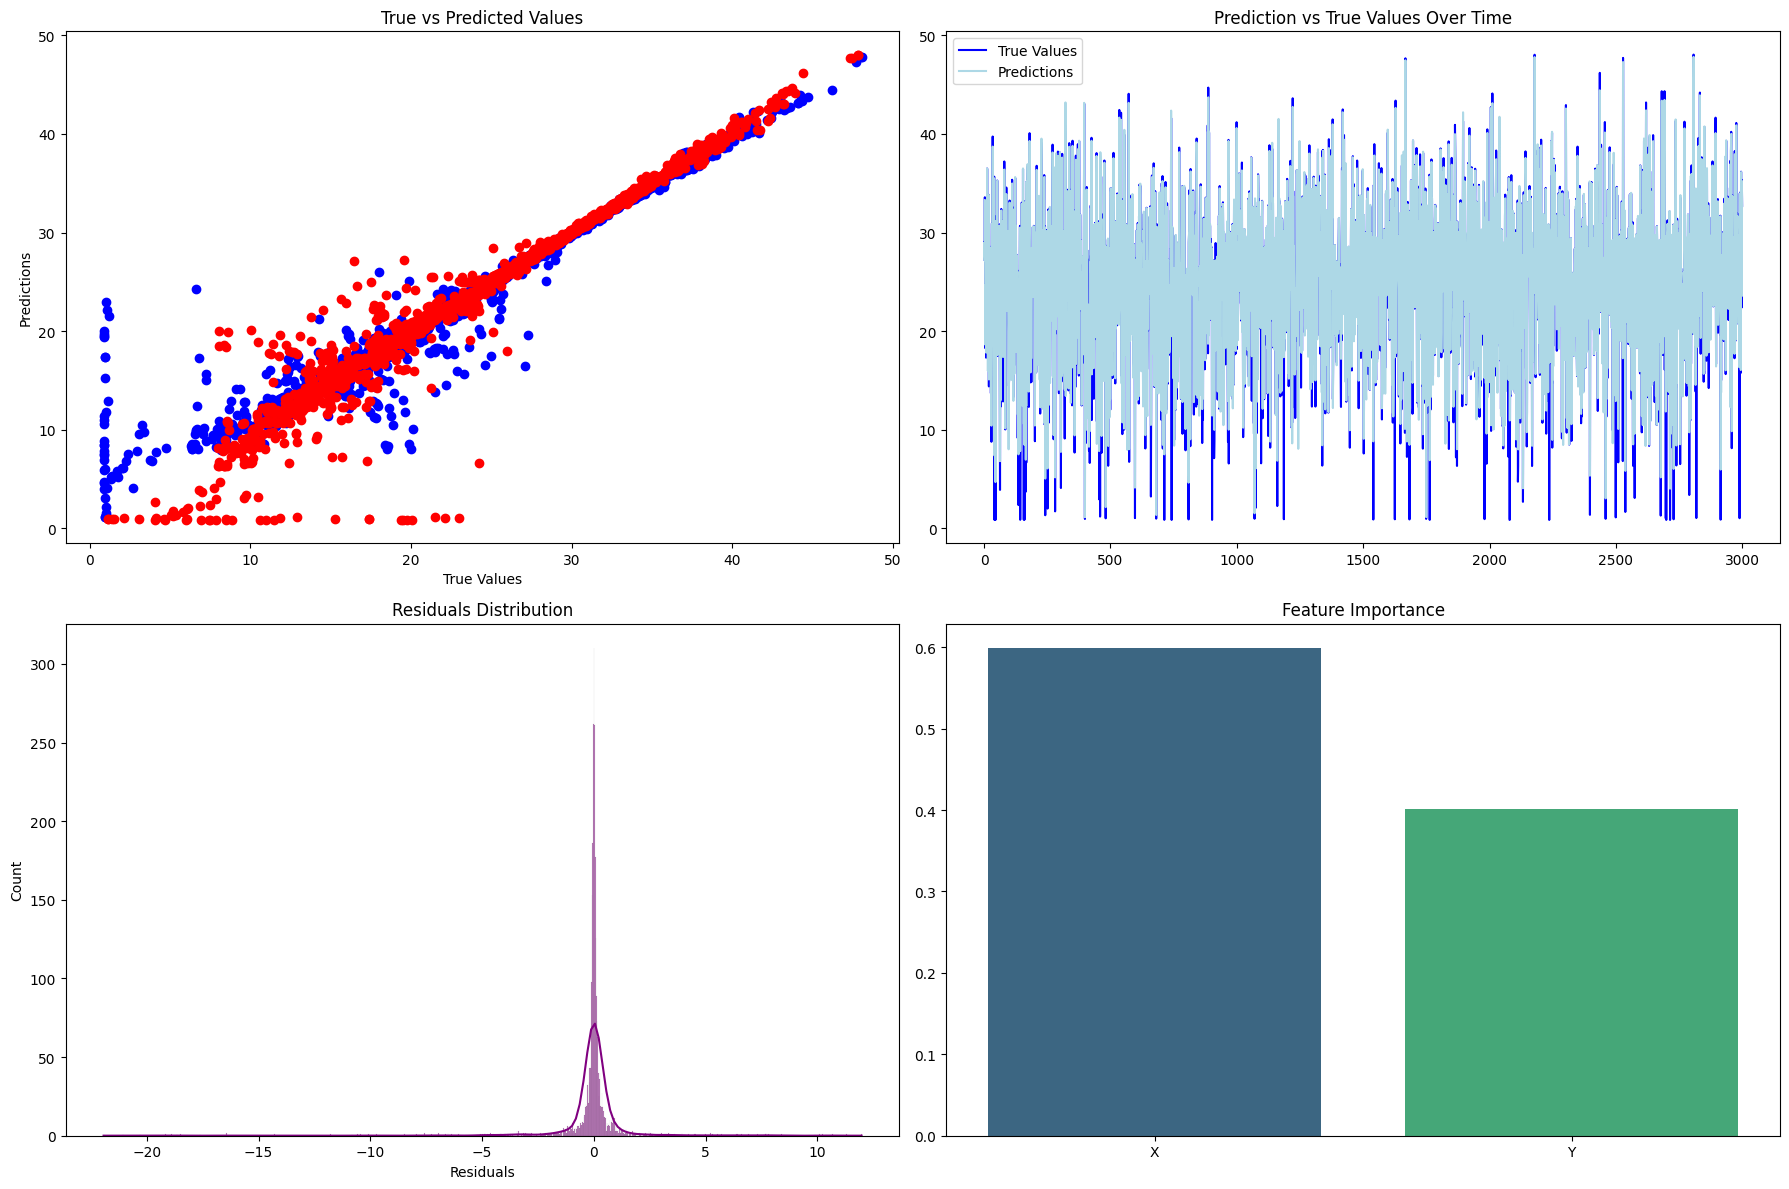

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Generate the Lorenz attractor dataset (same as before)
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

# Initial conditions and time points
initial_state = [0., 1., 1.05]
t = np.linspace(0, 25, 10000)  # time points

# Solve the system of differential equations
sol = solve_ivp(lorenz, (t[0], t[-1]), initial_state, t_eval=t)

# Extracting the solutions
x = sol.y[0]
y = sol.y[1]
z = sol.y[2]

# Combine into a dataset
data = np.column_stack((x, y, z))

# Step 2: Split the dataset into 70% training and 30% testing
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Use x and y to predict z
X_train = train_data[:, :2]
y_train = train_data[:, 2]

X_test = test_data[:, :2]
y_test = test_data[:, 2]

# Step 3: Train a more complex ML Model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Test the Model
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error: {mse}")
print(f"Optimized R^2 Score: {r2}")

# Plotting the results

# 1. True vs Predicted Values
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, color='blue', label='True Values')
plt.scatter(y_pred, y_test, color='red', label='Predictions')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")

# 2. Prediction vs True Values Over Time
plt.subplot(2, 2, 2)
plt.plot(y_test, color='blue', label='True Values')
plt.plot(y_pred, color='lightblue', label='Predictions')
plt.legend()
plt.title("Prediction vs True Values Over Time")

# 3. Residuals Plot
residuals = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel("Residuals")
plt.title("Residuals Distribution")

# 4. Feature Importance
plt.subplot(2, 2, 4)
importance = model.feature_importances_
sns.barplot(x=["X", "Y"], y=importance, palette="viridis")
plt.title("Feature Importance")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the CSV data
df = pd.read_csv('/Users/shreyupadhyay/Downloads/lorenze_attractor.csv')

# Divide the data into 70:30 ratio
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Prepare the features and target
X_train = train_data[['Homodyme Detector 1', 'Homodyme Detector 2', 'Homodyme Detector 3', 'Homodyme Detector 4']]
y_train = train_data['Random_Noise']
X_test = test_data[['Homodyme Detector 1', 'Homodyme Detector 2', 'Homodyme Detector 3', 'Homodyme Detector 4']]
y_test = test_data['Random_Noise']

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Repeat the training and testing process 4 times
n_repeats = 4
mse_scores = []

for i in range(n_repeats):
    print(f"Iteration {i+1}/{n_repeats}")
    
    # Use 3 times as training data and 1 time as testing data
    # Shuffle and split the data
    X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, y_train, test_size=0.25, random_state=i*10)

    # Train the model
    model.fit(X_train_part, y_train_part)

    # Test the model
    y_pred = model.predict(X_test_part)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test_part, y_pred)
    mse_scores.append(mse)

    print(f"Mean Squared Error for iteration {i+1}: {mse}")

# Final testing on the original test set
final_predictions = model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
print(f"\nFinal Test Mean Squared Error on the original test set: {final_mse}")

# Output the MSE scores
print("\nMSE Scores for each iteration:", mse_scores)


Iteration 1/4
Mean Squared Error for iteration 1: 0.08363939714364484
Iteration 2/4
Mean Squared Error for iteration 2: 0.12422478359520815
Iteration 3/4
Mean Squared Error for iteration 3: 0.16826061312210985
Iteration 4/4
Mean Squared Error for iteration 4: 0.18410627785609826

Final Test Mean Squared Error on the original test set: 0.13703326377499694

MSE Scores for each iteration: [0.08363939714364484, 0.12422478359520815, 0.16826061312210985, 0.18410627785609826]


# Data processing for Tackling Chaotic Noise in Continuous-Variable
Distributed Quantum Network2

This notebook accompanies the paper [X. Guo et. al  _Distributed quantum sensing in a continuous-variable entangled network_, Nature Physics (2019)](https://doi.org/10.1038/s41567-019-0743-x). 
It demonstrates how to get from the phase calibration data and the raw oscilloscope trace measurements to the main results of the study, presented in Figure 3 of the paper.

To run the notebook, the following data files must be present in the same folder:

* `distsens_phasecalibration.hdf5`
* `distsens_spectra.hdf5` and/or `distsens_raw.hdf5`


Furthermore, the following Python packages are required:

* numpy
* scipy
* matplotlib
* h5py
* jupyter


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import block_diag
from scipy import signal
import h5py

## Phase calibration

The purpose of the phase calibration is to determine how large phase shifts are induced on the probe light for given settings of the half-waveplates (manually set and read off by rotation mounts). The data consists of two sets of measurements: `phasecal_sq` for the squeezed (P) quadrature and `phasecal_asq` for the anti-squeezed (X) quadrature. Each set consists of an array of shape (4,5,40): 4 channels x 5 half-waveplate settings x 40 phase shift measurements.

In [ ]:
phase_file = h5py.File('distsens_phasecalibration.hdf5', 'r')
hwp = phase_file['HWPsettings'][()]
phasecal_sq = phase_file['sq_phases'][()]
phasecal_asq = phase_file['asq_phases'][()]

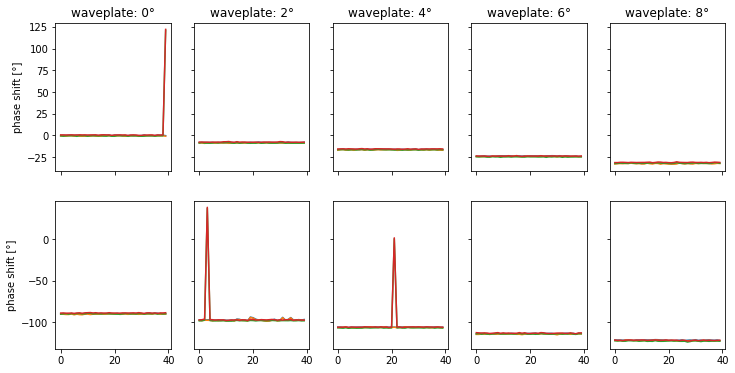

In [ ]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row', figsize=(12,6))
for i in range(5):
    axs[0, i].plot(phasecal_sq[:,i].T)
    axs[1, i].plot(phasecal_asq[:,i].T)
    axs[0, i].set_title('waveplate: {:.0f}°'.format(hwp[i]))
axs[0, 0].set_ylabel('phase shift [°]')
axs[1, 0].set_ylabel('phase shift [°]');

Remove obvious outliers (accidental errors) and replot:

In [ ]:
def outliers_to_nan(data, threshold=10):
    d = np.abs(data - np.median(data))
    data[d > threshold] = np.nan
    return data

for i in range(4):
    for j in range(5):
        phasecal_sq[i,j] = outliers_to_nan(phasecal_sq[i,j])
        phasecal_asq[i,j] = outliers_to_nan(phasecal_asq[i,j])

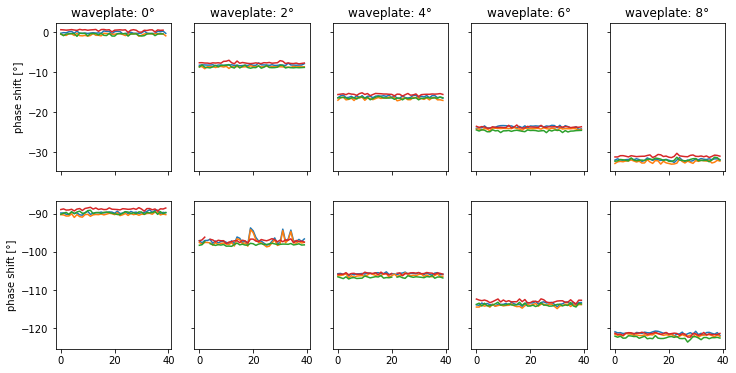

In [ ]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row', figsize=(12,6))
for i in range(5):
    axs[0, i].plot(phasecal_sq[:,i].T)
    axs[1, i].plot(phasecal_asq[:,i].T)
    axs[0, i].set_title('waveplate: {:.0f}°'.format(hwp[i]))
axs[0, 0].set_ylabel('phase shift [°]')
axs[1, 0].set_ylabel('phase shift [°]');

Calculate mean and standard deviation of the average phase shifts of the four channels:

In [ ]:
p_sq = np.mean(np.nanmean(phasecal_sq, axis=2), axis=0)
p_sq_std = 1/4 * np.sqrt(np.sum(np.nanstd(phasecal_sq, axis=2)**2, axis=0))

p_asq = np.mean(np.nanmean(phasecal_asq, axis=2), axis=0)
p_asq_std = 1/4 * np.sqrt(np.sum(np.nanstd(phasecal_asq, axis=2)**2, axis=0))

Get calibration - linear fit through the phase shifts:

In [ ]:
fun_lin = lambda x, k, b: k * x + b
phases_fit_sq, phases_cov_sq = curve_fit(fun_lin, hwp, p_sq, [-4, 0], p_sq_std)
phases_fit_asq, phases_cov_asq = curve_fit(fun_lin, hwp, p_asq, [-4, -90], p_asq_std)

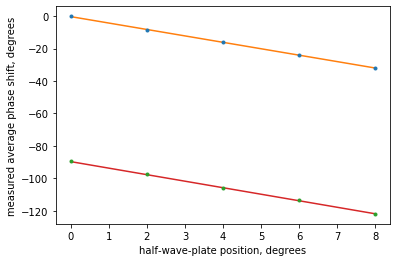

In [ ]:
plt.errorbar(hwp, p_sq, p_sq_std, fmt='.')
plt.plot(hwp, fun_lin(hwp, *phases_fit_sq))
plt.errorbar(hwp, p_asq, p_asq_std, fmt='.')
plt.plot(hwp, fun_lin(hwp, *phases_fit_asq))
plt.xlabel('half-wave-plate position, degrees')
plt.ylabel('measured average phase shift, degrees');

Half-waveplate positions used in actual measurements, converted to phase shifts (with a change of sign to make them positive - purely for aesthetics):

In [ ]:
hwp_sq = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
hwp_asq = np.array([0, 2, 4])

phases_sq = -fun_lin(hwp_sq, *phases_fit_sq)
phases_asq = -fun_lin(hwp_asq, *phases_fit_asq)

phases = np.r_[phases_sq, phases_asq]
phases_rad = phases * np.pi / 180

In [ ]:
phases_sq_std = np.sqrt(hwp_sq**2 * phases_cov_sq[0,0] + phases_cov_sq[1,1] + 
                        2 * hwp_sq * phases_cov_sq[0,1])
phases_asq_std = np.sqrt(hwp_asq**2 * phases_cov_asq[0,0] + phases_cov_asq[1,1] + 
                         2 * hwp_asq * phases_cov_asq[0,1])
phases_std = np.r_[phases_sq_std, phases_asq_std]
phases_std_rad = phases_std * np.pi / 180

The uncertainties on the calibrated phase shifts are so small and of similar size that we do not need to take them into account in the following (although we could, using e.g. the `scipy.odr` module to do fitting to data with errors in both x and y variables):

In [ ]:
txt = 'HWP setting {:.0f}° -> {:.2f}° ± {:.2f}°'
for i in range(12):
    print(txt.format(np.r_[hwp_sq, hwp_asq][i], phases[i], phases_std[i]))

HWP setting 0° -> 0.25° ± 0.09°
HWP setting 1° -> 4.21° ± 0.07°
HWP setting 2° -> 8.18° ± 0.06°
HWP setting 3° -> 12.14° ± 0.05°
HWP setting 4° -> 16.10° ± 0.05°
HWP setting 5° -> 20.06° ± 0.06°
HWP setting 6° -> 24.02° ± 0.07°
HWP setting 7° -> 27.99° ± 0.08°
HWP setting 8° -> 31.95° ± 0.10°
HWP setting 0° -> 89.70° ± 0.21°
HWP setting 2° -> 97.74° ± 0.15°
HWP setting 4° -> 105.78° ± 0.12°


## Get power spectral densities

Here are two options for getting the power spectral densities for each of the phase settings for each of the measurement series (corresponding to one point in Figure 3 in the paper):

1. Load the already processed spectra from the `distsens_spectra.hdf5` file.
2. Re-generate all the spectra from the raw oscilloscope data in `distsens_raw.hdf5`. This will take a few minutes and requires several GB of memory.

You only need to run one of the following two cells.

In [ ]:
# load pre-generated spectra

psd_file = h5py.File('distsens_spectra.hdf5', 'r')

f = psd_file['frequencies'][()]
psd_ent = [p[()] for p in psd_file['entangled/average'].values()]
psd_ent_var = [p[()] for p in psd_file['entangled/variance'].values()]
psd_ent_singles = [p[()] for p in psd_file['entangled_singlechannels/average'].values()]
psd_ent_singles_var = [p[()] for p in psd_file['entangled_singlechannels/variance'].values()]
psd_sep = [p[()] for p in psd_file['separable/average'].values()]
psd_sep_var = [p[()] for p in psd_file['separable/variance'].values()]

### Generate spectra

Generate spectra (PSDs) and variances of spectra from oscilloscope data. The data contained in `distsens_raw.hdf5` are the raw integer (unscaled) data obtained from the oscilloscope, only repackaged into an HDF5 container.:



In [ ]:
# re-generate spectra

# STEP 1
number_traces = 2000  # how many traces to include for each dataset - max 2000
slice_traces = slice(number_traces)
samplerate = 50e6
samples = 10000

# STEP 2
data_file = h5py.File('distsens_raw.hdf5', 'r')

psd_ent_singles = []
psd_ent_singles_var = []
psd_ent = []
psd_ent_var = []
psd_sep = []
psd_sep_var = []

# STEP 3
def buildPSD(traces):
    _, spectra = signal.periodogram(traces, fs=samplerate, nfft=samples, axis=-1)
    avgspectra = spectra.mean(-2)
    varspectra = spectra.var(-2) / spectra.shape[-2]
    return avgspectra, varspectra

# STEP 4
for data in data_file['entangled'].values():
    print('Processing ', data.name)
    print(' - calculating homodyne detector normalization')
    
    # STEP 4A
    sn_traces = np.array([ch[slice_traces] for ch in 
                          data['shotnoise/phase1'].values()])

    f, sn_spec = signal.periodogram(sn_traces, 
                                    fs=samplerate, nfft=samples, axis=-1)
    f = f / 1e6  # change to MHz
    sn_spec = sn_spec.mean(1)  # average over 2000 traces
    
    # normalize to the average shotnoise voltage of each channel 
    # in the 2.5-3.5 MHz band (indices 500-700 in the spectrum)
    scalefactors = np.sqrt(1 / sn_spec[:, 500:700].mean(1))

    print(' - reading data')
    
    # STEP 4B
    sq_traces = np.array([[ch[slice_traces] for ch in ph.values()] 
                          for ph in data['squeezed'].values()])
    sq_traces = sq_traces * scalefactors.reshape((1, 4, 1, 1))
    # take the average of the four homodyne detector signals
    sq_traces_combined = sq_traces.mean(1)

    asq_traces = np.array([[ch[slice_traces] for ch in ph.values()] 
                          for ph in data['antisqueezed'].values()])
    asq_traces = asq_traces * scalefactors.reshape((1, 4, 1, 1))
    # take the average of the four homodyne detector signals
    asq_traces_combined = asq_traces.mean(1)

    print(' - calculating PSD spectra')
    
    # STEP 4C
    psd = np.array([buildPSD(t) for t in sq_traces] + 
                   [buildPSD(t) for t in asq_traces])
    psd_ent_singles.append(psd[:,0])
    psd_ent_singles_var.append(psd[:,1])
    psd = np.array([buildPSD(t) for t in sq_traces_combined] + 
                   [buildPSD(t) for t in asq_traces_combined])
    psd_ent.append(psd[:,0])
    psd_ent_var.append(psd[:,1])

# STEP 5
for data in data_file['separable'].values():
    print('Processing ', data.name)
    print(' - calculating homodyne detector normalization')
    sn_trace = np.array(data['shotnoise/phase1/C1'])[slice_traces]

    _, sn_spec = signal.periodogram(sn_trace, 
                                    fs=samplerate, nfft=samples, axis=-1)
    sn_spec = sn_spec.mean(0)  
    scalefactor = np.sqrt(1 / sn_spec[500:700].mean())

    print(' - reading data')
    sq_traces = np.array([ph['C1'][slice_traces] for ph in 
                          data['squeezed'].values()])
    sq_traces = sq_traces * scalefactor

    asq_traces = np.array([ph['C1'][slice_traces] for ph in 
                           data['antisqueezed'].values()])
    asq_traces = asq_traces * scalefactor

    print(' - calculating PSD spectra')
    psd = np.array([buildPSD(t) for t in sq_traces] + 
                   [buildPSD(t) for t in asq_traces])
    psd_sep.append(psd[:,0])
    psd_sep_var.append(psd[:,1])

Processing  /entangled/power1
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /entangled/power2
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /entangled/power3
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /entangled/power4
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /entangled/power5
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /separable/power1
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /separable/power2
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /separable/power3
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /separable/power4
 - calcula

### Re-create figure 2 in the paper

Figure 2 in the paper shows the PSDs in a narrow region around the modulation frequency, 3 MHz, for the four individual channels and for their combination. In the paper the traces are shown for the first 6 phase shift settings, showing a gradually increasing signal peak. This number can be modified below.

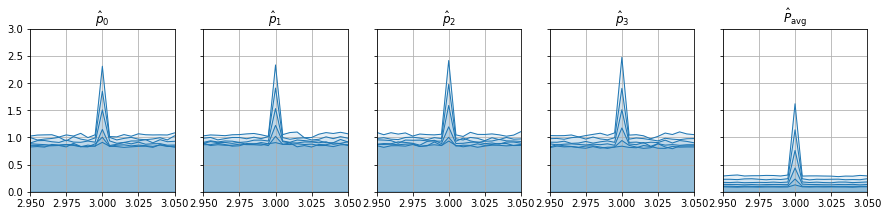

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

number_phases = 6  # how many phases (starting from 0°) to include in plot

for i in range(5):
    if i < 4:
        spectra = psd_ent_singles[2][:number_phases,i]
        label = r'$\hat{{p}}_{}$'.format(i)
    elif i == 4:
        spectra = psd_ent[2][:number_phases]
        label = r'$\hat{P}_\mathrm{avg}$'
        
    for s in spectra:
        axs[i].fill_between(f, s, color='C0', alpha=.1)
        axs[i].plot(f, s, color='C0', lw=1)
    axs[i].set_xlim(2.95, 3.05)
    axs[i].set_ylim(0, 3)
    axs[i].grid(True)
    axs[i].set_title(label)
    

## Calculate sensitivities from PSDs

To obtain the main result, we first extract the signal and noise levels from the various spectra, then use those numbers to calculate the sensitivities and photon numbers.

### Extract signal and noise levels from PSDs

From the narrow regions of the spectra shown above, extract the peak amplitude and noise levels (in units of amplitude, as per the description in our Supplementary Material).

1. Define array indices to extract the peak (a single point at 3 MHz) and the noise in the surrounding region between 2.95 and 3.05 MHz.
2. Define a function that takes a set of PSDs and PSD variances and outputs the signal, the noise and their standard deviations, following eq. (54) in SM. Allow for the different shot noise levels of the separable (snl = 1) and entangled (snl = 1/4 due to the averaging of four channels) measurements.
3. Define the models for the $\phi_\mathrm{avg}$-dependence of the signal and noise. These are given in eq. (44) in SM, although due to the normalization of the oscilloscope traces to the shot noise, $V_{sn}$ is already incorporated into $V_s$ and $V_n$.
4. Prepare empty lists to hold the signal, noise, and uncertainties for each phase shift setting for each power setting for each of the entangled and separable setups. Also prepare lists to hold the parameters and parameter covariances output from the curve fitting.
5. Extract the signal, noise and their uncertainties from all the entangled PSDs. Use SciPy's `optimize.curve_fit` function to fit the data to the two models for signal and noise, including in the fits the statistical uncertainties on these data.
6. Repeat for the separable PSDs.

In [ ]:
# STEP 1

# boolean indexing array selecting the frequency components neighbouring 3.00 MHz
noise_indices = ((2.95 <= f) & (f <= 3.05) & (f != 3))
peak_index = (f == 3)

# STEP 2
def signal_noise_error(psd, psd_var, snl=1):
    noisepower = psd[:, noise_indices].mean(1) / snl
    peaks = psd[:, peak_index].flatten() / snl
    
    noisepower_var = psd_var[:, noise_indices].mean(1) / snl**2
    peaks_var = psd_var[:, peak_index].flatten() / snl**2
    
    signalpower = (peaks - noisepower)
    noise = np.sqrt(noisepower)
    sig = np.sqrt(signalpower)
    
    noise_std = np.sqrt(noisepower_var / (4 * noisepower))
    sig_std = np.sqrt(peaks_var / (4 * peaks) + 
                      noisepower_var / (4 * noisepower))
    
    return sig, noise, sig_std, noise_std

# STEP 3
def model_signal(phi, amp, theta): 
    return amp * np.abs(np.sin(phi + theta))

def model_noise(phi, vsq, vasq, theta): 
    return np.sqrt(vsq**2 * np.cos(phi + theta)**2 +
                   vasq**2 * np.sin(phi + theta)**2)

# STEP 4
signal_ent = []
signal_ent_std = []
signal_ent_pfit = []
signal_ent_pcov = []
noise_ent = []
noise_ent_std = []
noise_ent_pfit = []
noise_ent_pcov = []
signal_sep = []
signal_sep_std = []
signal_sep_pfit = []
signal_sep_pcov = []
noise_sep = []
noise_sep_std = []
noise_sep_pfit = []
noise_sep_pcov = []

# STEP 5
for psd, psd_var in zip(psd_ent, psd_ent_var):
    sig, noise, sig_std, noise_std = signal_noise_error(psd, psd_var, snl=1/4)
    signal_ent.append(sig)
    noise_ent.append(noise)
    signal_ent_std.append(sig_std)
    noise_ent_std.append(noise_std)
    
    signal_pfit, signal_pcov = curve_fit(model_signal, phases_rad, sig, [1, 0],
                                         sig_std, True)
    noise_pfit, noise_pcov = curve_fit(model_noise, phases_rad, noise, [.2, 1, 0],
                                       noise_std, True)
    signal_ent_pfit.append(signal_pfit)
    signal_ent_pcov.append(signal_pcov)
    noise_ent_pfit.append(noise_pfit)
    noise_ent_pcov.append(noise_pcov)

# STEP 6
for psd, psd_var in zip(psd_sep, psd_sep_var):
    sig, noise, sig_std, noise_std = signal_noise_error(psd, psd_var, snl=1)
    signal_sep.append(sig)
    noise_sep.append(noise)
    signal_sep_std.append(sig_std)
    noise_sep_std.append(noise_std)
    
    signal_pfit, signal_pcov = curve_fit(model_signal, phases_rad, sig, [1, 0],
                                         sig_std, True)
    noise_pfit, noise_pcov = curve_fit(model_noise, phases_rad, noise, [.2, 1, 0],
                                       noise_std, True)
    signal_sep_pfit.append(signal_pfit)
    signal_sep_pcov.append(signal_pcov)
    noise_sep_pfit.append(noise_pfit)
    noise_sep_pcov.append(noise_pcov)

### For all measurement series, create figure like Fig. 10 in Supplement

Plot the signal values (left) and noise values (right) along with the fits. Nine pairs of plots; five for entangled setups at the different powers, four for the separable.

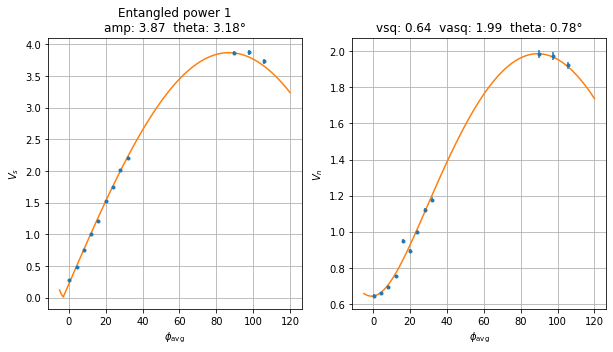

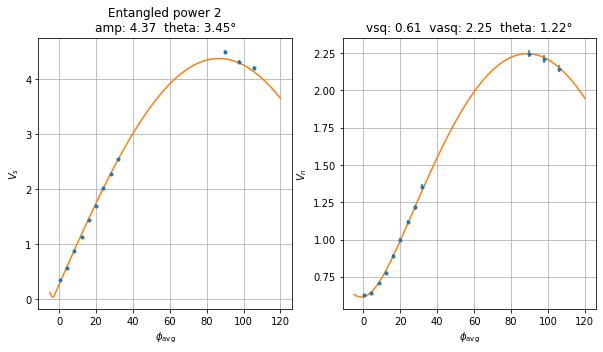

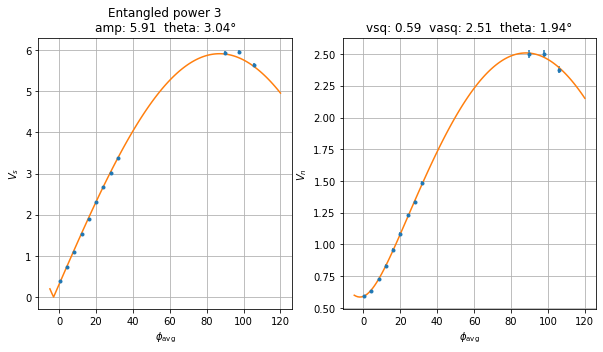

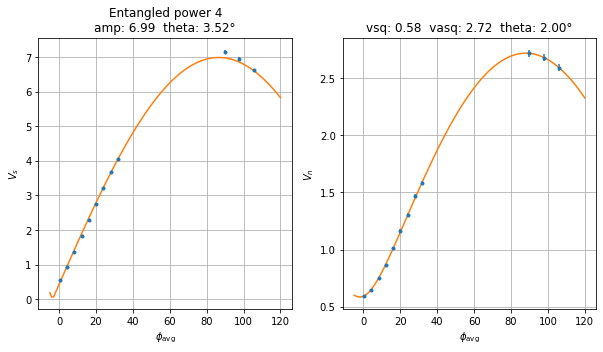

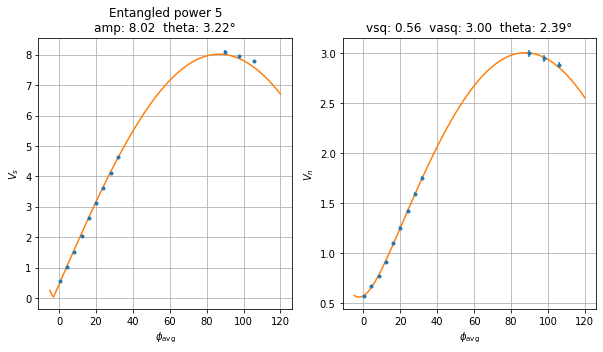

In [ ]:
ph = np.linspace(-5, 120, 126)
ph_rad = ph * np.pi / 180

for i in range(len(signal_ent)):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].errorbar(phases, signal_ent[i], signal_ent_std[i], phases_std, '.')
    axs[0].plot(ph, model_signal(ph_rad, *signal_ent_pfit[i]))
    axs[0].grid()
    axs[0].set_xlabel(r'$\phi_\mathrm{avg}$')
    axs[0].set_ylabel(r'$V_s$')
    axs[0].set_title('Entangled power {}\namp: {:.2f}  theta: {:.2f}°'.format(
        i + 1, signal_ent_pfit[i][0], signal_ent_pfit[i][1] * 180/np.pi))
    
    axs[1].errorbar(phases, noise_ent[i], noise_ent_std[i], phases_std, '.')
    axs[1].plot(ph, model_noise(ph_rad, *noise_ent_pfit[i]))
    axs[1].grid()
    axs[1].set_xlabel(r'$\phi_\mathrm{avg}$')
    axs[1].set_ylabel(r'$V_n$')
    axs[1].set_title('vsq: {:.2f}  vasq: {:.2f}  theta: {:.2f}°'.format(
        noise_ent_pfit[i][0], noise_ent_pfit[i][1], noise_ent_pfit[i][2] * 180/np.pi))

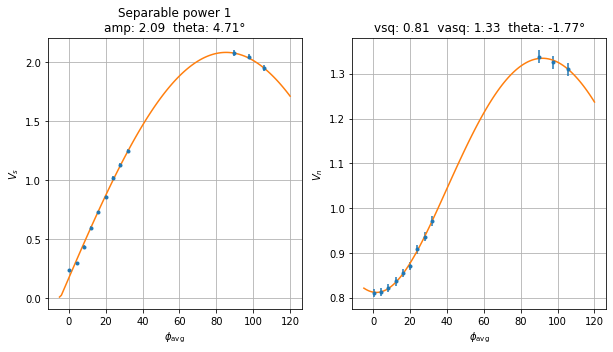

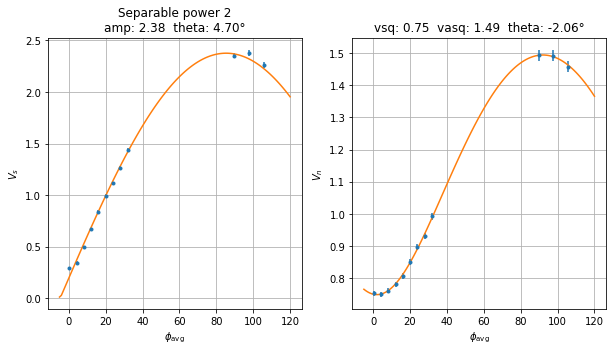

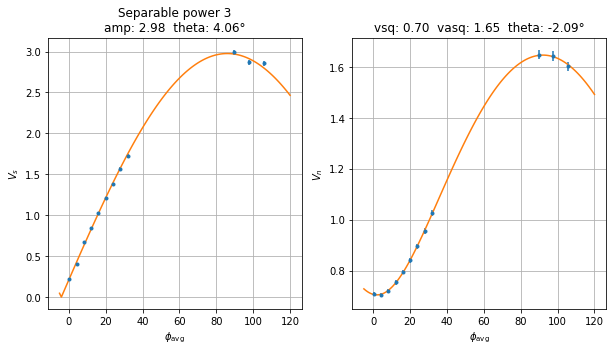

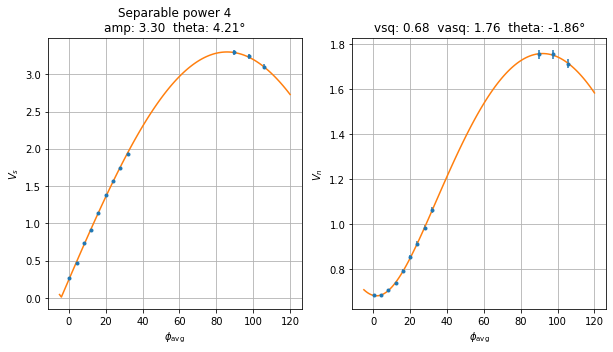

In [ ]:
for i in range(len(signal_sep)):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].errorbar(phases, signal_sep[i], signal_sep_std[i], phases_std, '.')
    axs[0].plot(ph, model_signal(ph_rad, *signal_sep_pfit[i]))
    axs[0].grid()
    axs[0].set_xlabel(r'$\phi_\mathrm{avg}$')
    axs[0].set_ylabel(r'$V_s$')
    axs[0].set_title('Separable power {}\namp: {:.2f}  theta: {:.2f}°'.format(
        i + 1, signal_sep_pfit[i][0], signal_sep_pfit[i][1] * 180/np.pi))
    
    axs[1].errorbar(phases, noise_sep[i], noise_sep_std[i], phases_std, '.')
    axs[1].plot(ph, model_noise(ph_rad, *noise_sep_pfit[i]))
    axs[1].grid()
    axs[1].set_xlabel(r'$\phi_\mathrm{avg}$')
    axs[1].set_ylabel(r'$V_n$')
    axs[1].set_title('vsq: {:.2f}  vasq: {:.2f}  theta: {:.2f}°'.format(
        noise_sep_pfit[i][0], noise_sep_pfit[i][1], noise_sep_pfit[i][2] * 180/np.pi))

### Calculate sensitivities and photon numbers

We determine the sensitivities for each of the nine measurements using the optimal parameters and parameter covariances from the fits. They are evaluated at $\phi_\mathrm{avg} = 0$. To estimate the photon numbers, we use the noise variances measured at our 0° phase shift settings of $P$ and $X$ (for squeezing photons) and the maximum signal amplitude, that is, the one measured at 0° phase shift of $X$ (for coherent photons).

1. Define a function to calculate the sensitivity from eq. (56) in SM based on the signal and noise models and fitted parameter estimates. The function also calculates the uncertainty on the sensitivity using linear error propagation with the full covariance matrices of the fitted parameters.

2. Define functions to estimate the photon numbers $N_{sqz}$ and $N_{coh}$ and their uncertainties from the data using eqs. (58-61) in SM. Includes a parameter to provide the number of modes, cf. the difference between eqs. (58-59) and (60-61).

3. Calculate sensitivities and photon numbers for the entangled and separable measurements and put in lists. For the separable measurements, the sensitivity is divided by $\sqrt{4}$ to account for the fact that we only measure a single sample, not four.

In [ ]:
# STEP 1
def sensitivity(signal_p, noise_p, signal_pcov, noise_pcov):
    A = model_noise(0, *noise_p)
    B = signal_p[0] * np.cos(signal_p[1])
    sens = A / B
    
    jac_A = np.array([noise_p[0] * np.cos(noise_p[2])**2 / A ,
                      noise_p[1] * np.sin(noise_p[2])**2 / A,
                      ((noise_p[1]**2 - noise_p[0]**2) * 
                       np.cos(noise_p[2]) * np.sin(noise_p[2]) / A)])
    var_A = jac_A @ noise_pcov @ jac_A
    var_A = jac_A @ np.diag(noise_pcov.diagonal()) @ jac_A
    
    jac_B = np.array([np.cos(signal_p[1]),
                      -signal_p[0] * np.sin(signal_p[1])])
    var_B = jac_B @ signal_pcov @ jac_B
    var_B = jac_B @ np.diag(signal_pcov.diagonal()) @ jac_B
    
    std = abs(sens) * np.sqrt(var_A / A**2 + var_B / B**2)
    
    return sens, std

# STEP 2
def photons_sq(noise, noise_std, modes):
    vsq = noise[0]
    vasq = noise[9]
    vsq_std = noise_std[0]
    vasq_std = noise_std[9]
    
    Nsq = 1/4 * (vsq**2 + vasq**2 - 2) / modes
    Nsq_std = np.sqrt(vsq**2 / 4 * vsq_std**2 + 
                      vasq**2 / 4 * vasq_std**2) / modes
        
    return Nsq, Nsq_std

def photons_coh(sig, sig_std, modes):
    amp = sig[9]
    amp_std = sig_std[9]
    
    Ncoh = amp**2 / 4 / modes
    Ncoh_std = amp / 2 * amp_std / modes
    
    return Ncoh, Ncoh_std

# STEP 3
M = 4
N_ent = []
N_ent_std = []
mu_ent = []
sigma_ent = []
sigma_ent_std = []
N_sep = []
N_sep_std = []
mu_sep = []
sigma_sep = []
sigma_sep_std = []

for s, scov, n, ncov in zip(signal_ent_pfit, signal_ent_pcov,
                            noise_ent_pfit, noise_ent_pcov):    
    sens, std = sensitivity(s, n, scov, ncov)
    sigma_ent.append(sens)
    sigma_ent_std.append(std)

for s, scov, n, ncov in zip(signal_sep_pfit, signal_sep_pcov,
                            noise_sep_pfit, noise_sep_pcov):
    sens, std = sensitivity(s, n, scov, ncov)
    sigma_sep.append(sens / np.sqrt(M))
    sigma_sep_std.append(std / np.sqrt(M))

for s, sstd, n, nstd in zip(signal_ent, signal_ent_std,
                            noise_ent, noise_ent_std):
    Nsq, Nsq_std = photons_sq(n, nstd, M)
    Ncoh, Ncoh_std = photons_coh(s, sstd, M)
    
    N_ent.append(Nsq + Ncoh)
    N_ent_std.append(np.sqrt(Nsq_std**2 + Ncoh_std**2))
    mu_ent.append(Nsq / (Nsq + Ncoh))   
    
for s, sstd, n, nstd in zip(signal_sep, signal_sep_std,
                            noise_sep, noise_sep_std):
    Nsq, Nsq_std = photons_sq(n, nstd, 1)
    Ncoh, Ncoh_std = photons_coh(s, sstd, 1)
    
    N_sep.append(Nsq + Ncoh)
    N_sep_std.append(np.sqrt(Nsq_std**2 + Ncoh_std**2))
    mu_sep.append(Nsq / (Nsq + Ncoh))   

### Re-create Fig. 3 in the paper

Finally, we plot the sensitivities versus photon number and compare with theory, as in the main result in Figure 3 of the paper.

First, define the theoretical optimized sensitivities, eqs. (4-5) in the paper or (27, 31) in SM:

In [ ]:
def sigma_ent_opt(M, N, eta):
    return (1 / (2 * M * N) * 
            np.sqrt((M * N * (1 - eta) + eta / 2 +
                     eta / 2 * np.sqrt(1 + 4 * M * N * (1 - eta))) /
                    (1 + eta / (M * N))))

def sigma_sep_opt(M, N, eta):
    return (1 / (2 * np.sqrt(M) * N) * 
            np.sqrt((N * (1 - eta) + eta / 2 +
                     eta / 2 * np.sqrt(1 + 4 * N * (1 - eta))) /
                    (1 + eta / (N))))

...and do the plot:

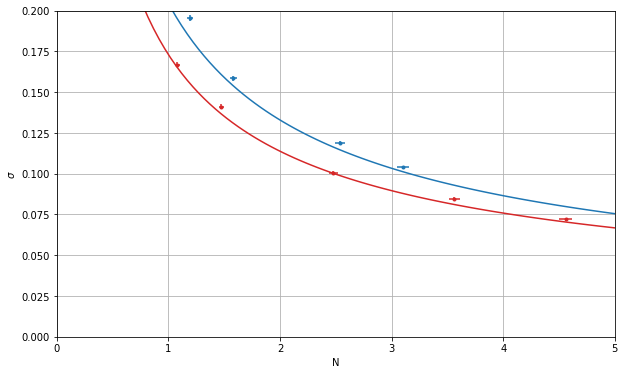

In [ ]:
N = np.linspace(.01, 5, 100)

fig = plt.figure(figsize=(10, 6))
plt.plot(N, sigma_ent_opt(M, N, .735), color='C3')
plt.errorbar(N_ent, sigma_ent, sigma_ent_std, N_ent_std, fmt='.', color='C3')

plt.plot(N, sigma_sep_opt(M, N, .735), color='C0')
plt.errorbar(N_sep, sigma_sep, sigma_sep_std, N_sep_std, fmt='.', color='C0')

plt.ylim(0, .2)
plt.xlim(0, 5)
plt.grid()
plt.xlabel('N')
plt.ylabel(r'$\sigma$');